## Step 1: Import Packages
Here we import all required packages for data manipulation (numpy, pandas), visualization (matplotlib, seaborn), and deep learning (TensorFlow and Keras). Setting a random seed ensures reproducibility

In [111]:
# Import all the necessary libraries
import os
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

# For machine learning and deep learning
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import RobustScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Bidirectional
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)


## Step 2: Load the Data
We load the data for each subject from the provided files. Each file is read into a DataFrame, and a new column subject_id is created to keep track of which subject each record belongs to. Finally, all data is concatenated into a single DataFrame.

In [29]:
# Define the list of files (update the paths as necessary)
list_of_files = [
    'Protocol/subject101.dat',
    'Protocol/subject102.dat',
    'Protocol/subject103.dat',
    'Protocol/subject104.dat',
    'Protocol/subject105.dat',
    'Protocol/subject106.dat',
    'Protocol/subject107.dat',
    'Protocol/subject108.dat',
    'Protocol/subject109.dat'
]

# Define activity mapping as a dictionary for later use in EDA
activityIDdict = {
    0: 'transient', 1: 'lying', 2: 'sitting', 3: 'standing', 4: 'walking',
    5: 'running', 6: 'cycling', 7: 'Nordic_walking', 9: 'watching_TV',
    10: 'computer_work', 11: 'car driving', 12: 'ascending_stairs',
    13: 'descending_stairs', 16: 'vacuum_cleaning', 17: 'ironing',
    18: 'folding_laundry', 19: 'house_cleaning', 20: 'playing_soccer',
    24: 'rope_jumping'
}

# Define column names
colNames = ["timestamp", "activityID", "heartrate"]

IMUhand = ['handTemperature', 'handAcc16_1', 'handAcc16_2', 'handAcc16_3',
           'handAcc6_1', 'handAcc6_2', 'handAcc6_3',
           'handGyro1', 'handGyro2', 'handGyro3',
           'handMagne1', 'handMagne2', 'handMagne3',
           'handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4']

IMUchest = ['chestTemperature', 'chestAcc16_1', 'chestAcc16_2', 'chestAcc16_3',
            'chestAcc6_1', 'chestAcc6_2', 'chestAcc6_3',
            'chestGyro1', 'chestGyro2', 'chestGyro3',
            'chestMagne1', 'chestMagne2', 'chestMagne3',
            'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4']

IMUankle = ['ankleTemperature', 'ankleAcc16_1', 'ankleAcc16_2', 'ankleAcc16_3',
            'ankleAcc6_1', 'ankleAcc6_2', 'ankleAcc6_3',
            'ankleGyro1', 'ankleGyro2', 'ankleGyro3',
            'ankleMagne1', 'ankleMagne2', 'ankleMagne3',
            'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4']

# Combine all column names
columns = colNames + IMUhand + IMUchest + IMUankle

# Load data efficiently from each file into a single DataFrame
data_list = []

for file in list_of_files:
    try:
        # Read the file assuming whitespace-separated values; adjust separator if needed
        subject = pd.read_table(file, header=None, sep=r'\s+')
        subject.columns = columns

        # Extract subject id (e.g., 101 from 'subject101.dat')
        subject_id = int(re.search(r'\d+', file).group())
        subject['subject_id'] = subject_id

        data_list.append(subject)
        print(f"Loaded {file}")

    except FileNotFoundError:
        print(f"File not found: {file}")
    except Exception as e:
        print(f"Error reading {file}: {e}")

# Combine all subject DataFrames
data_pamap2 = pd.concat(data_list, ignore_index=True)
print(f"\nTotal rows loaded: {len(data_pamap2)}")


Loaded Protocol/subject101.dat
Loaded Protocol/subject102.dat
Loaded Protocol/subject103.dat
Loaded Protocol/subject104.dat
Loaded Protocol/subject105.dat
Loaded Protocol/subject106.dat
Loaded Protocol/subject107.dat
Loaded Protocol/subject108.dat
Loaded Protocol/subject109.dat

Total rows loaded: 2872533


## Step 3: Data Cleaning
We remove the 'transient' activity rows (activityID == 0), convert all entries to numeric (coercing errors to NaN) and then interpolate missing values. This cleaning ensures that the dataset is ready for analysis and modeling.

In [30]:
def clean_data(data):
    """
    Cleans the PAMAP2 dataset by:
    - Removing transient activity (activityID == 0)
    - Converting data to numeric and coercing errors to NaN
    - Interpolating missing values
    """
    # Remove rows with transient activity
    data = data.drop(data[data['activityID'] == 0].index)
    
    # Convert all data to numeric, set errors as NaN
    data = data.apply(pd.to_numeric, errors='coerce')
    
    # Interpolate to fill NaN values
    data = data.interpolate()
    return data

# Clean the data
data_clean = clean_data(data_pamap2)
data_clean.reset_index(drop=True, inplace=True)
display(data_clean.head(15))

# Check for any remaining missing values
print(data_clean.isnull().sum())


,timestamp,activityID,heartrate,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,...,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4,subject_id
0,37.66,1,NaN,30.375,2.21530,8.27915,5.58753,2.24689,8.55387,5.77143,...,-0.027714,0.001752,-61.1081,-36.8636,-58.3696,1.0,0.0,0.0,0.0,101
1,37.67,1,NaN,30.375,2.29196,7.67288,5.74467,2.27373,8.14592,5.78739,...,0.000945,0.006007,-60.8916,-36.3197,-58.3656,1.0,0.0,0.0,0.0,101
2,37.68,1,NaN,30.375,2.29090,7.14240,5.82342,2.26966,7.66268,5.78846,...,-0.052422,-0.004882,-60.3407,-35.7842,-58.6119,1.0,0.0,0.0,0.0,101
3,37.69,1,NaN,30.375,2.21800,7.14365,5.89930,2.22177,7.25535,5.88000,...,-0.018844,0.026950,-60.7646,-37.1028,-57.8799,1.0,0.0,0.0,0.0,101
4,37.70,1,100.0,30.375,2.30106,7.25857,6.09259,2.20720,7.24042,5.95555,...,-0.048878,-0.006328,-60.2040,-37.1225,-57.8847,1.0,0.0,0.0,0.0,101
5,37.71,1,100.0,30.375,2.07165,7.25965,6.01218,2.19238,7.21038,6.01604,...,-0.026906,0.004125,-61.3257,-36.9744,-57.7501,1.0,0.0,0.0,0.0,101
6,37.72,1,100.0,30.375,2.41148,7.59780,5.93915,2.23988,7.46679,6.03053,...,-0.032277,-0.006866,-61.5520,-36.9632,-57.9957,1.0,0.0,0.0,0.0,101
7,37.73,1,100.0,30.375,2.32815,7.63431,5.70686,2.31663,7.64745,6.01495,...,-0.016621,0.006548,-61.5738,-36.1724,-59.3487,1.0,0.0,0.0,0.0,101
8,37.74,1,100.0,30.375,2.25096,7.78598,5.62821,2.28637,7.70801,5.93935,...,0.020393,-0.011880,-61.7741,-37.1744,-58.1199,1.0,0.0,0.0,0.0,101
9,37.75,1,100.0,30.375,2.14107,7.52262,5.78141,2.31538,7.72276,5.78828,...,-0.010763,0.005133,-60.7680,-37.4206,-58.8735,1.0,0.0,0.0,0.0,101


timestamp            0
activityID           0
heartrate            4
handTemperature      0
handAcc16_1          0
handAcc16_2          0
handAcc16_3          0
handAcc6_1           0
handAcc6_2           0
handAcc6_3           0
handGyro1            0
handGyro2            0
handGyro3            0
handMagne1           0
handMagne2           0
handMagne3           0
handOrientation1     0
handOrientation2     0
handOrientation3     0
handOrientation4     0
chestTemperature     0
chestAcc16_1         0
chestAcc16_2         0
chestAcc16_3         0
chestAcc6_1          0
chestAcc6_2          0
chestAcc6_3          0
chestGyro1           0
chestGyro2           0
chestGyro3           0
chestMagne1          0
chestMagne2          0
chestMagne3          0
chestOrientation1    0
chestOrientation2    0
chestOrientation3    0
chestOrientation4    0
ankleTemperature     0
ankleAcc16_1         0
ankleAcc16_2         0
ankleAcc16_3         0
ankleAcc6_1          0
ankleAcc6_2          0
ankleAcc6_3

We observed only 4 missing values in the heartrate column. Since this constitutes a very small fraction of the data, we removed these rows for simplicity without adversely affecting our analysis.

In [31]:
# Remove rows with missing values in the 'heartrate' column
data_clean = data_clean.dropna(subset=['heartrate']).reset_index(drop=True)
print("Remaining missing values after removal:")
print(data_clean.isnull().sum())


Remaining missing values after removal:
timestamp            0
activityID           0
heartrate            0
handTemperature      0
handAcc16_1          0
handAcc16_2          0
handAcc16_3          0
handAcc6_1           0
handAcc6_2           0
handAcc6_3           0
handGyro1            0
handGyro2            0
handGyro3            0
handMagne1           0
handMagne2           0
handMagne3           0
handOrientation1     0
handOrientation2     0
handOrientation3     0
handOrientation4     0
chestTemperature     0
chestAcc16_1         0
chestAcc16_2         0
chestAcc16_3         0
chestAcc6_1          0
chestAcc6_2          0
chestAcc6_3          0
chestGyro1           0
chestGyro2           0
chestGyro3           0
chestMagne1          0
chestMagne2          0
chestMagne3          0
chestOrientation1    0
chestOrientation2    0
chestOrientation3    0
chestOrientation4    0
ankleTemperature     0
ankleAcc16_1         0
ankleAcc16_2         0
ankleAcc16_3         0
ankleAcc6_1      

## 4. Exploratory Data Analysis (EDA)
## Step 4.1: Activity Distribution
We plot a bar chart to understand the frequency of each activity type. This helps verify that the dataset is balanced or identify the need for data augmentation if an activity is under-represented.

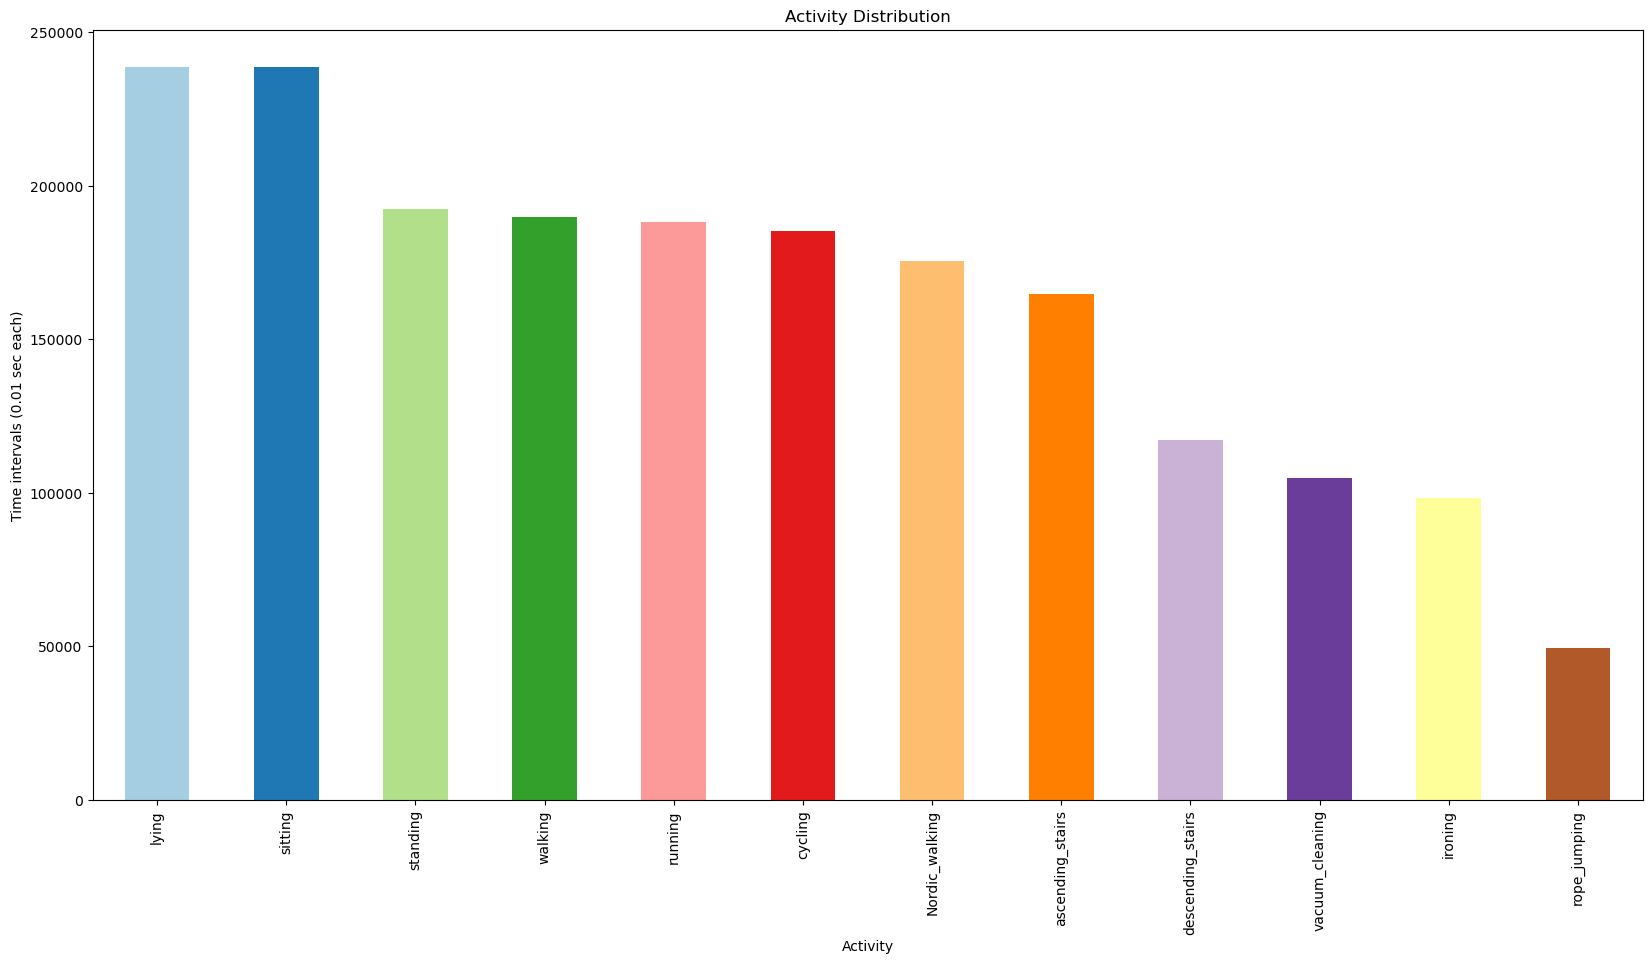

In [32]:
# Create a copy for EDA so the original cleaned data remains intact
data_clean_copy = data_clean.copy()

# Plot the distribution of activities
plt.figure(figsize=(20,10))
unique_activities = np.unique(data_clean_copy['activityID'])
N = len(unique_activities)
# Map the activity IDs to names for x-axis labels
xticks_lbl = [activityIDdict.get(x, str(x)) for x in unique_activities.tolist()]
data_clean_copy['activityID'].value_counts().plot(kind="bar", color=plt.cm.Paired(np.arange(N)))
plt.xticks(ticks=np.arange(N), labels=xticks_lbl)
plt.title("Activity Distribution")
plt.xlabel("Activity")
plt.ylabel("Time intervals (0.01 sec each)")
plt.show()


The bar chart clearly shows the distribution of activity types in the dataset. We see that the classes are relatively balanced—with no extreme over- or under-representation. This suggests that we likely do not need additional data augmentation techniques for handling class imbalance.

Next Steps:
In the next section, we'll dive deeper into other descriptive statistics (Step 4.2) and further explore the relationship between features (like heart rate) and activities before moving to data scaling and model building.

## Step 4.2: Descriptive Statistics
The descriptive statistics give insights into the data range, mean, standard deviation, etc. Notice key details—like the range of 'heartrate'—which may later influence model preprocessing or scaling.

In [33]:
# Display summary statistics for numeric columns
display(data_clean.describe())


,timestamp,activityID,heartrate,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,...,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4,subject_id
count,1.942868e+06,1.942868e+06,1.942868e+06,1.942868e+06,1.942868e+06,1.942868e+06,1.942868e+06,1.942868e+06,1.942868e+06,1.942868e+06,...,1.942868e+06,1.942868e+06,1.942868e+06,1.942868e+06,1.942868e+06,1.942868e+06,1.942868e+06,1.942868e+06,1.942868e+06,1.942868e+06
mean,1.705205e+03,8.081845e+00,1.074879e+02,3.275126e+01,-4.952988e+00,3.585071e+00,3.602227e+00,-4.886301e+00,3.573588e+00,3.786926e+00,...,-3.652769e-02,6.658551e-03,-3.158965e+01,1.397038e+00,1.725055e+01,3.812286e-01,-8.998455e-03,3.023862e-01,-5.698139e-02,1.045664e+02
std,1.093461e+03,6.174787e+00,2.699218e+01,1.794161e+00,6.239660e+00,6.893710e+00,3.956960e+00,6.245970e+00,6.589670e+00,3.942863e+00,...,6.383291e-01,2.012900e+00,1.834636e+01,2.168674e+01,1.970625e+01,3.036793e-01,5.714341e-01,3.326730e-01,4.800393e-01,2.333049e+00
min,3.120000e+01,1.000000e+00,5.700000e+01,2.487500e+01,-1.453670e+02,-1.043010e+02,-1.014520e+02,-6.121470e+01,-6.184170e+01,-6.193470e+01,...,-1.812690e+01,-1.401960e+01,-1.728650e+02,-1.379080e+02,-1.027160e+02,1.521280e-06,-9.568760e-01,-8.768380e-01,-9.972810e-01,1.010000e+02
25%,7.445400e+02,3.000000e+00,8.600000e+01,3.168750e+01,-8.969760e+00,1.058210e+00,1.161468e+00,-8.866492e+00,1.057688e+00,1.363370e+00,...,-1.066090e-01,-4.417065e-01,-4.171630e+01,-1.248460e+01,3.794838e+00,1.426340e-01,-6.129585e-01,4.915975e-03,-5.378710e-01,1.020000e+02
50%,1.480330e+03,6.000000e+00,1.040000e+02,3.312500e+01,-5.450280e+00,3.526535e+00,3.431385e+00,-5.378540e+00,3.567830e+00,3.662640e+00,...,-3.950100e-03,-2.327840e-03,-3.400810e+01,7.769950e-01,1.876760e+01,2.838390e-01,0.000000e+00,3.055330e-01,0.000000e+00,1.050000e+02
75%,2.663610e+03,1.300000e+01,1.240000e+02,3.406250e+01,-9.577327e-01,6.453465e+00,6.531530e+00,-9.058955e-01,6.458670e+00,6.775980e+00,...,1.162580e-01,9.181848e-02,-1.790600e+01,1.783900e+01,3.121160e+01,5.600183e-01,6.153730e-01,5.960645e-01,4.382873e-01,1.070000e+02
max,4.245680e+03,2.400000e+01,2.020000e+02,3.550000e+01,6.285960e+01,1.556990e+02,1.577600e+02,5.282140e+01,6.225980e+01,6.192340e+01,...,1.358820e+01,1.652880e+01,9.155160e+01,9.424780e+01,1.469000e+02,1.000000e+00,9.595380e-01,9.514820e-01,9.961050e-01,1.090000e+02


We observe that heartrate ranges from 57 to 202, which seems valid for physically demanding activities.

IMU sensor data (Acc, Gyro, etc.) varies widely, confirming the presence of outliers — making RobustScaler a good choice.

No columns appear to have suspiciously negative or zero values (other than valid sensor readings), so we can proceed forward!


## Step 4.3: Heart Rate Analysis
Here, we calculate and plot the average heart rate for each activity group. This visualization confirms that more physically demanding activities (like running) yield higher heart rates compared to sedentary ones (like sitting).

Average Heart Rates by Activity:
activityID
1      75.539915
2      80.012614
3      88.554771
4     112.786174
5     156.590944
6     124.884246
7     123.829853
12    129.525475
13    129.156243
16    104.194956
17     90.062321
24    161.985048
Name: heartrate, dtype: float64


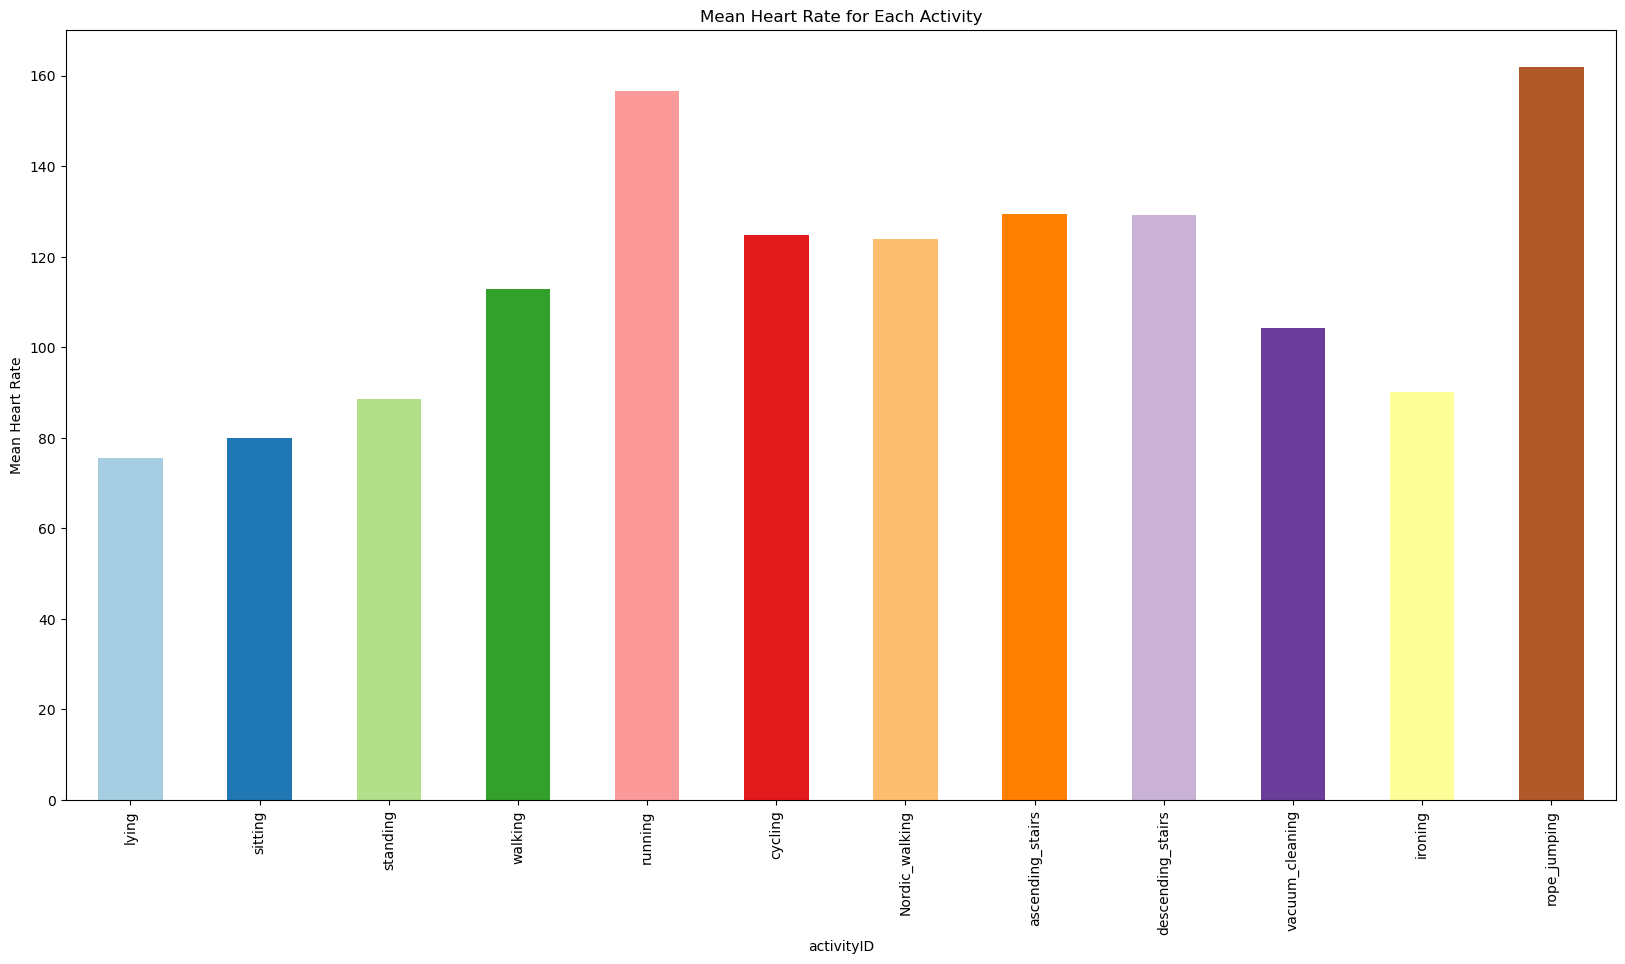

In [34]:
# Calculate average heart rate per activity group
avg_hr_by_activity = data_clean['heartrate'].groupby(data_clean['activityID']).mean()
print("Average Heart Rates by Activity:")
print(avg_hr_by_activity)

plt.figure(figsize=(20,10))
# Map the indices to activity names using our dictionary
avg_hr_by_activity.index = avg_hr_by_activity.index.map(lambda x: activityIDdict.get(x, str(x)))
plt.title("Mean Heart Rate for Each Activity")
plt.xlabel("Activity Name")
plt.ylabel("Mean Heart Rate")
avg_hr_by_activity.plot(kind='bar', color=plt.cm.Paired(np.arange(N)))
plt.show()


We calculated and plotted the mean heart rate for each activity, as shown in the bar chart above. Here are some key takeaways:

    Higher Heart Rate for High-Intensity Activities: Activities like running, rope jumping, or playing soccer show higher average heart rates, indicating greater physical exertion.

    Lower Heart Rate for Sedentary Activities: Lying, sitting, and watching TV have noticeably lower mean heart rates, which aligns with lower levels of physical activity.

    Expected Patterns: These results confirm that the sensor data (heartrate) behaves as expected, capturing the difference in intensity between sedentary and vigorous activities.

This insight into heart rate ranges across different activities validates that the dataset can effectively capture physiological responses to varying activity levels. It also supports the idea that heart rate could be an important feature in our upcoming classification models.

## Step 5: Additional Preprocessing

Train/Test Split: Using subjects 107 & 108 for testing ensures our model generalizes well to “unseen” individuals.

Dropping Non-Informative Columns: The subject_id and timestamp columns do not help in predicting the activity, so we remove them.

Scaling the Data: We use RobustScaler because it’s less sensitive to outliers, which can arise from sudden sensor spikes.

Create X and y: Finally, we split the scaled data into features (X) and labels (y) for our machine learning models.

In [35]:
# --- Step 5: Additional Preprocessing – Scaling and Splitting ---

# 1) Define or reuse helper functions if not already defined
def scale_data(train_data, test_data, features):
    """
    Scales the given train and test data using RobustScaler.
    """
    from sklearn.preprocessing import RobustScaler

    scaler = RobustScaler()
    # Make copies to avoid changing original dataframes
    train_data_scaled = train_data.copy()
    test_data_scaled = test_data.copy()
    
    # Fit the scaler on train data, then transform both train and test
    scaler.fit(train_data_scaled[features])
    train_data_scaled.loc[:, features] = scaler.transform(train_data_scaled[features])
    test_data_scaled.loc[:, features] = scaler.transform(test_data_scaled[features])
    
    return train_data_scaled, test_data_scaled

def get_features_for_scale(all_cols, remove_list):
    """
    Returns a list of columns to scale by excluding the ones we don't want to scale,
    such as the label (activityID) or other non-numeric columns.
    """
    return [col for col in all_cols if col not in remove_list]

# 2) Split the cleaned data into train and test sets
def get_test_data(data):
    return data[data["subject_id"].isin([107, 108])]

def get_train_data(data):
    return data[~data["subject_id"].isin([107, 108])]

test_data = get_test_data(data_clean)
train_data = get_train_data(data_clean)

# 3) Drop unneeded columns
test_data = test_data.drop(["subject_id", "timestamp"], axis=1)
train_data = train_data.drop(["subject_id", "timestamp"], axis=1)

# 4) Identify feature columns and scale them
features_for_scale = get_features_for_scale(list(train_data.columns), ['activityID'])
train_sc, test_sc = scale_data(train_data, test_data, features_for_scale)

# 5) Separate X and y
X_train = train_sc.drop('activityID', axis=1).values
y_train = train_sc['activityID'].values
X_test = test_sc.drop('activityID', axis=1).values
y_test = test_sc['activityID'].values

# 6) Check shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (1447990, 52)
y_train shape: (1447990,)
X_test shape: (494878, 52)
y_test shape: (494878,)


## Step 6: Feature Importance Analysis

In this step, we evaluate the importance of each of our 52 features using a Random Forest classifier.

Why?

Feature Reduction: By identifying the most important features (e.g., the top 25), we can reduce the dimensionality of the input data.

Model Simplification: A smaller feature set can speed up training and improve model generalization.

Data-Driven Decision: The results will help justify which features are retained for sequence modeling in later steps.

We use the scaled training data (X_train) and its corresponding labels (y_train), and we compute the importance scores for each feature.

Feature Ranking:
1. heartrate (0.1031)
2. handTemperature (0.0823)
3. chestTemperature (0.0787)
4. ankleTemperature (0.0578)
5. chestAcc16_3 (0.0448)
6. chestMagne2 (0.0428)
7. chestAcc6_3 (0.0396)
8. ankleMagne3 (0.0371)
9. chestMagne3 (0.0340)
10. handAcc6_1 (0.0237)
11. ankleMagne1 (0.0220)
12. handAcc16_1 (0.0215)
13. handMagne1 (0.0213)
14. chestOrientation1 (0.0201)
15. chestMagne1 (0.0193)
16. ankleOrientation4 (0.0186)
17. ankleOrientation2 (0.0176)
18. chestAcc6_2 (0.0168)
19. chestAcc16_2 (0.0158)
20. handAcc6_3 (0.0157)
21. ankleOrientation1 (0.0153)
22. ankleOrientation3 (0.0153)
23. chestOrientation4 (0.0143)
24. chestOrientation3 (0.0140)
25. ankleAcc6_1 (0.0129)
26. handAcc16_3 (0.0124)
27. handMagne2 (0.0123)
28. ankleMagne2 (0.0120)
29. chestOrientation2 (0.0119)
30. handMagne3 (0.0119)
31. handOrientation2 (0.0115)
32. ankleAcc6_2 (0.0114)
33. ankleGyro3 (0.0113)
34. handOrientation1 (0.0109)
35. ankleAcc16_1 (0.0106)
36. handAcc6_2 (0.0100)
37. handAcc16_2 (0.0097)
3

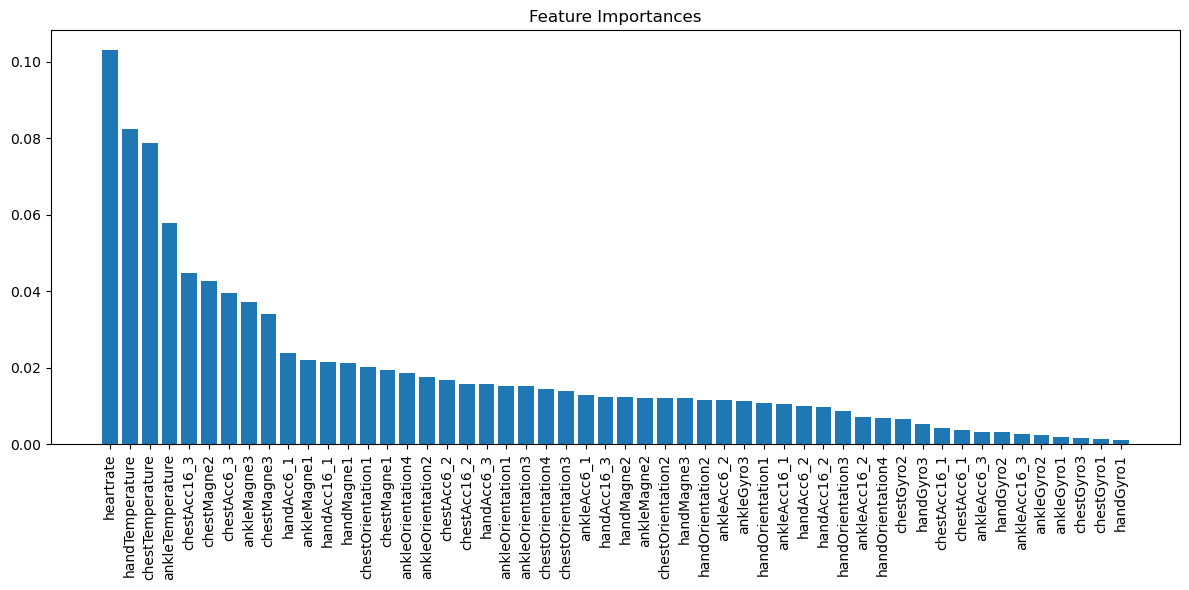

In [37]:
# Optionally, we may choose to use a subset of the training data for speed:
X_train_sample = X_train  # Or: X_train[np.random.choice(X_train.shape[0], 100000, replace=False)]
y_train_sample = y_train  # Use the corresponding labels

# Create and fit a Random Forest classifier on the sampled training data
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_sample, y_train_sample)

# Extract feature importances from the model
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort indices in descending order

# Print out the ranked feature importances
print("Feature Ranking:")
for i, idx in enumerate(indices):
    print("{}. {} ({:.4f})".format(i + 1, features_for_scale[idx], importances[idx]))

# Plot the feature importances
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), [features_for_scale[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()


From our Random Forest analysis, we obtained the following key observations regarding feature importance:
Top Features:
The most important features are:

heartrate (0.1031)

handTemperature (0.0823)

chestTemperature (0.0787)

ankleTemperature (0.0578)

chestAcc16_3 (0.0448)
… ....

Although we started with 52 features, many features contribute only marginally to the prediction of the activity. By selecting some of the top features, we can simplify our model, reduce training time, and potentially improve generalization by removing less informative (and possibly noisy) features. The top features, such as 'heartrate' and various temperature readings, make intuitive sense as indicators of activity intensity and type.

## 7: Reducing Features & Preparing Sequences
## Step 7.1: Filter Data to Selected Features

We decided to keep the top 25 features (trying) identified in Step 6. In this step, we create new versions of our training and test sets (scaled), retaining only those features.

Why?

Simplicity & Efficiency: Reducing feature dimensionality can speed up training and reduce overfitting.

Preserving Key Signals: By including only the most important features, we aim to maintain (or improve) model performance.

In [ ]:
# Number of features to keep
topN = 25  # trying

# Indices were sorted in descending order of importance in Step 6
selected_indices = indices[:topN]  # topN important feature indices
selected_feature_names = [features_for_scale[i] for i in selected_indices]

print(f"Top {topN} features selected:")
for feature in selected_feature_names:
    print(feature)

# Create new DataFrames with only these selected features
X_train_reduced = train_sc[selected_feature_names].values
X_test_reduced  = test_sc[selected_feature_names].values

print("\nShapes after feature reduction:")
print("X_train_reduced:", X_train_reduced.shape)
print("X_test_reduced:", X_test_reduced.shape)


Top 25 features selected:
heartrate
handTemperature
chestTemperature
ankleTemperature
chestAcc16_3
chestMagne2
chestAcc6_3
ankleMagne3
chestMagne3
handAcc6_1
ankleMagne1
handAcc16_1
handMagne1
chestOrientation1
chestMagne1
ankleOrientation4
ankleOrientation2
chestAcc6_2
chestAcc16_2
handAcc6_3
ankleOrientation1
ankleOrientation3
chestOrientation4
chestOrientation3
ankleAcc6_1

Shapes after feature reduction:
X_train_reduced: (1447990, 25)
X_test_reduced: (494878, 25)


## Step 7.2: Preparing Sequences for LSTM/GRU

With our feature set reduced, we now recreate time-based sequences using only the selected features. The output sequences will have a shape (samples, timesteps, topN).

Why Now?

We prefer to do sequence creation after feature reduction so that we don’t waste time generating (and discarding) sequences for less important features.

Each sample will span a fixed window of time_steps points, allowing our LSTM to capture temporal dependencies.

In [ ]:
# Reuse our sequence creation function, e.g. create_sequences()
def create_sequences(X, y, time_steps=20):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i + time_steps])
        y_seq.append(y[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

# Choose time window
TIME_STEPS = 20  # same value we had before, or experiment with new ones

# Generate sequences for reduced feature set
X_train_seq_reduced, y_train_seq_reduced = create_sequences(X_train_reduced, y_train, TIME_STEPS)
X_test_seq_reduced,  y_test_seq_reduced  = create_sequences(X_test_reduced,  y_test,  TIME_STEPS)

print("X_train_seq_reduced shape:", X_train_seq_reduced.shape)
print("y_train_seq_reduced shape:", y_train_seq_reduced.shape)
print("X_test_seq_reduced shape:",  X_test_seq_reduced.shape)
print("y_test_seq_reduced shape:",  y_test_seq_reduced.shape)


X_train_seq_reduced shape: (1447970, 20, 25)
y_train_seq_reduced shape: (1447970,)
X_test_seq_reduced shape: (494858, 20, 25)
y_test_seq_reduced shape: (494858,)


## Step 7.3: Encoding Labels

Our activity labels (i.e., y_train_seq_reduced and y_test_seq_reduced) are still in their original integer form (e.g., 1, 2, 3, etc.). Since the activity IDs are not necessarily sequential (they include values like 12, 16, etc.), we will use a LabelEncoder to remap them into a sequential range (0, 1, 2, …, n-1).

This encoding is necessary for our loss function (sparse_categorical_crossentropy), which expects labels in the range [0, n_classes-1].

In [41]:
# Create a LabelEncoder instance
le = LabelEncoder()

# Encode the training and test labels from the reduced sequences
y_train_seq_reduced_enc = le.fit_transform(y_train_seq_reduced)
y_test_seq_reduced_enc = le.transform(y_test_seq_reduced)

# Display unique encoded labels to verify
print("Unique encoded labels (training):", np.unique(y_train_seq_reduced_enc))


Unique encoded labels (training): [ 0  1  2  3  4  5  6  7  8  9 10 11]


The original activity IDs (which were not sequential) were then encoded into a sequential range of 0–11, corresponding to the 12 unique activities present.

## Step 8: Building the Baseline LSTM Model

With our data now preprocessed into sequences that use only our top 25 features—and with our activity labels encoded into a sequential range—we can now build our baseline LSTM model.

Model Architecture:

LSTM Layer (64 units): Processes the sequential data (each sample is a sequence of 20 timesteps with 25 features).

Dropout Layer (50%): Helps prevent overfitting by randomly dropping units during training.

Dense Output Layer: Uses softmax activation for predicting one of the 12 activity classes.

Training Setup:

Loss Function: sparse_categorical_crossentropy (works with our integer-encoded labels).

Optimizer: Adam

Metrics: Accuracy



In [ ]:
# Determine the number of classes based on the encoded labels
num_classes = len(np.unique(y_train_seq_reduced_enc))
print("Number of classes:", num_classes)

# Build the baseline LSTM model
model = Sequential([
    # LSTM layer: 64 units, takes sequences of (TIME_STEPS, number of features) as input.
    LSTM(64, input_shape=(TIME_STEPS, 25), return_sequences=False),
    # Dropout layer: Helps to reduce overfitting.
    Dropout(0.5),
    # Dense layer: Outputs probability for each class using softmax activation.
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Training parameters
epochs = 10       # van sdjust this as needed.
batch_size = 256  # will experiment with different batch sizes if desired.

# Train the model using the reduced feature sequences and encoded labels.
history = model.fit(
    X_train_seq_reduced,
    y_train_seq_reduced_enc,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test_seq_reduced, y_test_seq_reduced_enc)
)

# Evaluate the model on the test data.
test_loss, test_acc = model.evaluate(X_test_seq_reduced, y_test_seq_reduced_enc, verbose=0)
print("Test Accuracy: {:.2f}%".format(test_acc * 100))


Number of classes: 12


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        23,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,820 (93.05 KB)

 Trainable params: 23,820 (93.05 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5657/5657 ━━━━━━━━━━━━━━━━━━━━ 67s 12ms/step - accuracy: 0.9081 - loss: 0.3111 - val_accuracy: 0.4508 - val_loss: 3.3455
Epoch 2/10
5657/5657 ━━━━━━━━━━━━━━━━━━━━ 56s 10ms/step - accuracy: 0.9895 - loss: 0.0379 - val_accuracy: 0.3963 - val_loss: 4.0328
Epoch 3/10
5657/5657 ━━━━━━━━━━━━━━━━━━━━ 56s 10ms/step - accuracy: 0.9936 - loss: 0.0234 - val_accuracy: 0.4428 - val_loss: 3.9956
Epoch 4/10
5657/5657 ━━━━━━━━━━━━━━━━━━━━ 56s 10ms/step - accuracy: 0.9950 - loss: 0.0183 - val_accuracy: 0.3670 - val_loss: 4.6670
Epoch 5/10
5657/5657 ━━━━━━━━━━━━━━━━━━━━ 56s 10ms/step - accuracy: 0.9960 - loss: 0.0149 - val_accuracy: 0.4045 - val_loss: 4.3671
Epoch 6/10
5657/5657 ━━━━━━━━━━━━━━━━━━━━ 54s 10ms/step - accuracy: 0.9967 - loss: 0.0121 - val_accuracy: 0.3395 - val_loss: 4.7246
Epoch 7/10
5657/5657 ━━━━━━━━━━━━━━━━━━━━ 56s 10ms/step - accuracy: 0.9969 - loss: 0.0114 - val_accuracy: 0.3696 - val_loss: 4.5103
Epoch 8/10
5657/5657 ━━━━━━━━━━━━━━━━━━━━ 56s 10ms/step - accuracy: 0.9974 -

## Step 9: Save the Baseline Model

In [43]:
# Save the baseline LSTM model
model.save("baseline_lstm_model.h5")
print("Baseline LSTM model saved as 'baseline_lstm_model.h5'")


Baseline LSTM model saved as 'baseline_lstm_model.h5'


Baseline LSTM Model Results:

Number of Classes: 12

Training Accuracy: ~99.7%

Validation Accuracy: ~39.9%

Training Loss: ~0.0084

Validation Loss: ~4.77

Observations:

The model achieves nearly perfect training accuracy, indicating that it is overfitting the training data.

The significant drop in accuracy on the validation set shows poor generalization.

This baseline will serve as a benchmark for further improvements (e.g., adjusting dropout, reducing model complexity, adding regularization, and comparing with a GRU-based model).

Next Steps:
We will now load the saved baseline model as necessary and implement improvements to enhance generalization and overall performance.

**->mentor update from last week: good reporting is required! in the notebook, try GRU.**

## Step 10: Improvement, Fine-Tuning & Optimization

Our baseline LSTM model achieved a high training accuracy but overfitted on the validation set. To address this, we will:

1. Implement Callbacks (EarlyStopping & ModelCheckpoint):

    EarlyStopping prevents prolonged overfitting by halting training when improvements cease.

    ModelCheckpoint saves the best performing model (based on validation loss or accuracy).

2. Tune Hyperparameters & Architecture:

    Adjust dropout rate and L2 regularization to reduce overfitting.

    Consider changing batch size, learning rate, or LSTM units.

    Potentially stack multiple LSTM layers or reduce them if the model is too complex.

3. Use Different Model Variants:

    Experiment with GRU instead of LSTM, as it may train faster and sometimes generalize better with less data.

    Compare results with the baseline LSTM for conclusive insights.

4. Load & Save Models:

    We save each LSTM model with a distinct filename (e.g., baseline_lstm_model.h5, l2_lstm_model.keras, l2_small_bi_lstm_model.keras).
    
    This naming convention will continue for GRU and other model experiments (if implemented), ensuring fair comparisons and reproducibility.

## 10.1: Implementing Callbacks(EarlyStopping and ModelCheckpoints)

In [ ]:
# Load baseline model
model = load_model("baseline_lstm_model.h5")

# Recompile the model with a fresh optimizer instance
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint("improved_lstm_model.keras", monitor='val_loss', save_best_only=True)
]

history = model.fit(
    X_train_seq_reduced, 
    y_train_seq_reduced_enc,
    epochs=20,
    batch_size=256,
    validation_data=(X_test_seq_reduced, y_test_seq_reduced_enc),
    callbacks=callbacks
)


Epoch 1/20
5657/5657 ━━━━━━━━━━━━━━━━━━━━ 65s 11ms/step - accuracy: 0.9979 - loss: 0.0078 - val_accuracy: 0.3878 - val_loss: 4.9275
Epoch 2/20
5657/5657 ━━━━━━━━━━━━━━━━━━━━ 56s 10ms/step - accuracy: 0.9979 - loss: 0.0077 - val_accuracy: 0.3885 - val_loss: 5.3556
Epoch 3/20
5657/5657 ━━━━━━━━━━━━━━━━━━━━ 55s 10ms/step - accuracy: 0.9980 - loss: 0.0076 - val_accuracy: 0.4189 - val_loss: 4.5478
Epoch 4/20
5657/5657 ━━━━━━━━━━━━━━━━━━━━ 55s 10ms/step - accuracy: 0.9982 - loss: 0.0067 - val_accuracy: 0.3649 - val_loss: 5.3443
Epoch 5/20
5657/5657 ━━━━━━━━━━━━━━━━━━━━ 55s 10ms/step - accuracy: 0.9984 - loss: 0.0058 - val_accuracy: 0.4001 - val_loss: 4.9781
Epoch 6/20
5657/5657 ━━━━━━━━━━━━━━━━━━━━ 56s 10ms/step - accuracy: 0.9984 - loss: 0.0061 - val_accuracy: 0.3889 - val_loss: 5.3222


In [ ]:
best_model = load_model("improved_lstm_model.keras")
test_loss, test_accuracy = best_model.evaluate(X_test_seq_reduced, y_test_seq_reduced_enc)
print(f"Test Accuracy from best saved model: {test_accuracy * 100:.2f}%")


15465/15465 ━━━━━━━━━━━━━━━━━━━━ 12s 767us/step - accuracy: 0.5308 - loss: 3.3638
Test Accuracy from best saved model: 41.89%


We enhanced our baseline LSTM model by implementing EarlyStopping and ModelCheckpoint callbacks:

EarlyStopping was used with a patience of 3 to prevent unnecessary training once validation loss stopped improving.

ModelCheckpoint saved the best version of the model (based on validation loss) during training as improved_lstm_model.keras.

Results Summary
Training Accuracy (Epoch 6): ~99.84%

Validation Accuracy (Epoch 6): ~38.89%

Validation Loss: ~5.32

Test Accuracy from Best Saved Model: 41.89%

Observations:

This version of the model slightly outperformed the original baseline LSTM (test accuracy ~39.9%), indicating that callback-based fine-tuning improved generalization slightly.

Training was faster and more efficient due to early stopping.

The model is saved and reusable for deployment or further analysis.

## **10.2A: Adding L2 Regularization to Reduce Overfitting**

In this step, we aim to improve the generalization ability of our LSTM model by introducing **L2 regularization**, also known as weight decay.

> **Why L2 Regularization?**  
> While dropout helps prevent overfitting by randomly disabling units during training, L2 regularization works by **penalizing large weight values**, encouraging the model to maintain simpler and more generalizable patterns. This can be especially effective when combined with dropout.

**What We Changed:**
- Rebuilt the LSTM model from scratch using the same structure as the previous version.
- Added `kernel_regularizer=l2(0.001)` to both the LSTM and Dense layers.
- Kept dropout (now set to 0.3) for additional regularization.
- Retained `EarlyStopping` and `ModelCheckpoint` to monitor validation performance.

**Expected Outcome:**  
We expect this model to have reduced overfitting and potentially improved test accuracy compared to:
- The baseline LSTM (~39.9% accuracy)
- The dropout + callback-enhanced LSTM (~41.89% accuracy)

**The best version of this model will be saved as:** `l2_lstm_model.keras`


In [56]:
# Define a new LSTM model with L2 regularization and dropout
model_l2 = Sequential([
    LSTM(64, 
         input_shape=(X_train_seq_reduced.shape[1], X_train_seq_reduced.shape[2]),
         activation='tanh',
         return_sequences=False,
         kernel_regularizer=l2(0.001)),
    
    Dropout(0.3),
    
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    
    Dense(len(np.unique(y_train_seq_reduced_enc)), activation='softmax')
])

# Compile the model
model_l2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint("l2_lstm_model.keras", monitor='val_loss', save_best_only=True)
]

# Train the model
history_l2 = model_l2.fit(
    X_train_seq_reduced,
    y_train_seq_reduced_enc,
    epochs=20,
    batch_size=256,
    validation_data=(X_test_seq_reduced, y_test_seq_reduced_enc),
    callbacks=callbacks
)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
5657/5657 ━━━━━━━━━━━━━━━━━━━━ 70s 12ms/step - accuracy: 0.9045 - loss: 0.3880 - val_accuracy: 0.5034 - val_loss: 2.6877
Epoch 2/20
5657/5657 ━━━━━━━━━━━━━━━━━━━━ 62s 11ms/step - accuracy: 0.9876 - loss: 0.0717 - val_accuracy: 0.4899 - val_loss: 3.3233
Epoch 3/20
5657/5657 ━━━━━━━━━━━━━━━━━━━━ 64s 11ms/step - accuracy: 0.9906 - loss: 0.0575 - val_accuracy: 0.5447 - val_loss: 2.9968
Epoch 4/20
5657/5657 ━━━━━━━━━━━━━━━━━━━━ 59s 10ms/step - accuracy: 0.9922 - loss: 0.0505 - val_accuracy: 0.4194 - val_loss: 4.1941


In [57]:
# Load the best model saved by ModelCheckpoint
best_l2_model = load_model("l2_lstm_model.keras")

# Evaluate on the test set
test_loss, test_accuracy = best_l2_model.evaluate(X_test_seq_reduced, y_test_seq_reduced_enc)
print(f"Test Accuracy from L2-regularized model: {test_accuracy * 100:.2f}%")


15465/15465 ━━━━━━━━━━━━━━━━━━━━ 12s 792us/step - accuracy: 0.6277 - loss: 1.9430
Test Accuracy from L2-regularized model: 50.34%


We trained a new LSTM model with both **dropout** and **L2 regularization** to address overfitting and improve generalization.

The model was trained using:
- `Dropout(0.3)` layers
- `kernel_regularizer=l2(0.001)` in LSTM and Dense layers
- `EarlyStopping` to prevent unnecessary epochs
- `ModelCheckpoint` to save the best model during training

**Test Accuracy from this model: 50.34%**

> This is a significant improvement over our previous best (~41.89%), clearly showing that L2 regularization effectively boosted generalization.  
> This version is saved as `l2_lstm_model.keras` and will now serve as the new benchmark


## 10.2B: Reducing LSTM Units for Simpler Architecture

In this step, we explore how reducing the number of LSTM units from **64 to 32** impacts model performance.

> **Why we are trying a Smaller Model?**  
> While deeper models with more units can capture complex patterns, they are also more prone to **overfitting** and take longer to train.  
> A **simpler architecture** might train faster and generalize better on unseen data — especially when paired with dropout and L2 regularization.

**What We Changed:**
- Reduced LSTM layer units from **64 -> 32**
- Retained `kernel_regularizer=l2(0.001)` to prevent overfitting
- Maintained `Dropout(0.3)` for regularization
- Continued using `EarlyStopping` and `ModelCheckpoint` for training monitoring

**Expected Outcome:**  
We expect this model to potentially reduce overfitting further and test whether a **smaller model** performs comparably or even better than the larger LSTM (which achieved **~50.34% accuracy**).

**The best version of this model will be saved as:**  
`l2_lstm_small_model.keras`


In [59]:
# Define a simpler LSTM model (32 units instead of 64)
model_small = Sequential([
    LSTM(32, 
         input_shape=(X_train_seq_reduced.shape[1], X_train_seq_reduced.shape[2]),
         activation='tanh',
         return_sequences=False,
         kernel_regularizer=l2(0.001)),
    
    Dropout(0.3),
    
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    
    Dense(len(np.unique(y_train_seq_reduced_enc)), activation='softmax')
])

# Compile the model
model_small.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint("l2_lstm_small_model.keras", monitor='val_loss', save_best_only=True)
]

# Train the model
history_small = model_small.fit(
    X_train_seq_reduced,
    y_train_seq_reduced_enc,
    epochs=20,
    batch_size=256,
    validation_data=(X_test_seq_reduced, y_test_seq_reduced_enc),
    callbacks=callbacks
)


Epoch 1/20
5657/5657 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - accuracy: 0.8606 - loss: 0.5162 - val_accuracy: 0.5750 - val_loss: 2.2898
Epoch 2/20
5657/5657 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.9741 - loss: 0.1275 - val_accuracy: 0.4707 - val_loss: 3.7866
Epoch 3/20
5657/5657 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - accuracy: 0.9834 - loss: 0.0898 - val_accuracy: 0.3426 - val_loss: 5.1347
Epoch 4/20
5657/5657 ━━━━━━━━━━━━━━━━━━━━ 32s 6ms/step - accuracy: 0.9867 - loss: 0.0754 - val_accuracy: 0.3125 - val_loss: 5.2571


In [60]:
# Load the best-performing model saved during training
best_small_model = load_model("l2_lstm_small_model.keras")

# Evaluate on the test set
test_loss, test_accuracy = best_small_model.evaluate(X_test_seq_reduced, y_test_seq_reduced_enc)
print(f"Test Accuracy from small LSTM model: {test_accuracy * 100:.2f}%")


15465/15465 ━━━━━━━━━━━━━━━━━━━━ 8s 538us/step - accuracy: 0.7307 - loss: 1.3660
Test Accuracy from small LSTM model: 57.50%


We trained a smaller LSTM model with **32 units** (instead of 64), combined with dropout and L2 regularization.

The model was trained using:
- `LSTM(32)` with `kernel_regularizer=l2(0.001)`
- `Dropout(0.3)` after LSTM and Dense layers
- `EarlyStopping` to halt training on plateau
- `ModelCheckpoint` to save the best-performing model

**Model saved as:** `l2_lstm_small_model.keras`

---

Test Accuracy from this model: **57.50%**

This is the **best performance so far**, improving significantly over:
- The LSTM + L2 model (**50.34%**)
- The LSTM + dropout + callbacks model (**41.89%**)
- The baseline LSTM (**39.86%**)

This result strongly suggests that:
- **Simpler architectures** can generalize better
- Overfitting from large-capacity models was holding back performance

## 10.2C: Stacked LSTM Layers for Deeper Sequential Learning

In this step, we explore whether adding **more depth** to our LSTM model can enhance its ability to learn temporal patterns across time steps.

> **Why Stacked LSTM?**  
> A deeper LSTM model can capture complex sequential features by stacking multiple layers.  
> The **first layer** captures low-level patterns, and the **second layer** refines them into higher-level representations.

**What We Changed:**
- Introduced a **second LSTM layer**.
- Set `return_sequences=True` in the first LSTM so its output can feed into the second.
- Retained `Dropout(0.3)` and `kernel_regularizer=l2(0.001)` in key layers.
- Continued using `EarlyStopping` and `ModelCheckpoint`.

**Expected Outcome:**
We aim to see if this deeper model provides a performance boost over the simpler LSTM (which achieved **57.50% accuracy**) or if it suffers from overfitting due to added complexity.

**The best version of this model will be saved as:**  
`l2_stacked_lstm_model.keras`


In [ ]:
# Define stacked LSTM model
model_stacked = Sequential([
    LSTM(64, 
         return_sequences=True, 
         input_shape=(X_train_seq_reduced.shape[1], X_train_seq_reduced.shape[2]), 
         activation='tanh', 
         kernel_regularizer=l2(0.001)),
    
    Dropout(0.3),

    LSTM(32, 
         return_sequences=False, 
         activation='tanh', 
         kernel_regularizer=l2(0.001)),
    
    Dropout(0.3),

    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),

    Dense(len(np.unique(y_train_seq_reduced_enc)), activation='softmax')
])

# Compile the model
model_stacked.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint("l2_stacked_lstm_model.keras", monitor='val_loss', save_best_only=True)
]

# Train the model
history_stacked = model_stacked.fit(
    X_train_seq_reduced,
    y_train_seq_reduced_enc,
    epochs=20,
    batch_size=256,
    validation_data=(X_test_seq_reduced, y_test_seq_reduced_enc),
    callbacks=callbacks
)


In [63]:
# Load the best stacked LSTM model saved during training
best_stacked_model = load_model("l2_stacked_lstm_model.keras")

# Evaluate on the test set
test_loss, test_accuracy = best_stacked_model.evaluate(X_test_seq_reduced, y_test_seq_reduced_enc)
print(f"Test Accuracy from stacked LSTM model: {test_accuracy * 100:.2f}%")


15465/15465 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 0.4507 - loss: 3.0996
Test Accuracy from stacked LSTM model: 37.84%


We trained a deeper stacked LSTM model by introducing a second LSTM layer to capture more complex sequential patterns.

The model was configured with:
- Two LSTM layers (64 -> 32 units) with `return_sequences=True` in the first
- `Dropout(0.3)` for regularization
- `kernel_regularizer=l2(0.001)` in LSTM and Dense layers
- `EarlyStopping` and `ModelCheckpoint` callbacks

**Test Accuracy from this model: 37.84%**

This result shows a significant drop compared to our previous best (57.50% from the small LSTM model). It indicates that the deeper architecture may have introduced **excessive complexity**, making it prone to **overfitting** and less generalizable to unseen data.

While deeper models can be powerful, this experiment reinforces that **simpler LSTM architectures with regularization** can outperform deeper ones for this dataset.


## **10.2D: Using Bidirectional LSTM for Enhanced Temporal Learning**

In this step, we experiment with a **Bidirectional LSTM** architecture to determine if processing sequences in both forward and backward directions can boost model performance.

> **Why Bidirectional LSTM?**  
> Traditional LSTM processes sequences in one direction (past -> future).  
> However, in activity recognition, the full sequence is available. Bidirectional LSTM can learn from both past **and** future context simultaneously, which might improve accuracy.

**What We Changed:**
- Replaced the single `LSTM()` layer with `Bidirectional(LSTM())`.
- Used 64 units inside the LSTM layer (same as original baseline).
- Maintained regularization techniques:
  - `kernel_regularizer=l2(0.001)`
  - `Dropout(0.3)`
- Retained `EarlyStopping` and `ModelCheckpoint`.

**Expected Outcome:**  
We expect this model to better capture contextual information across the entire sequence and potentially outperform the previous best model (small L2-regularized LSTM @ **57.50% accuracy**).

**The best version of this model will be saved as:** `l2_bi_lstm_model.keras`


In [65]:
# Define the Bidirectional LSTM model
model_bi = Sequential([
    Bidirectional(LSTM(64, 
                       activation='tanh',
                       return_sequences=False,
                       kernel_regularizer=l2(0.001)), 
                  input_shape=(X_train_seq_reduced.shape[1], X_train_seq_reduced.shape[2])),
    
    Dropout(0.3),
    
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    
    Dense(len(np.unique(y_train_seq_reduced_enc)), activation='softmax')
])

# Compile the model
model_bi.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint("l2_bi_lstm_model.keras", monitor='val_loss', save_best_only=True)
]

# Train the model
history_bi = model_bi.fit(
    X_train_seq_reduced,
    y_train_seq_reduced_enc,
    epochs=20,
    batch_size=256,
    validation_data=(X_test_seq_reduced, y_test_seq_reduced_enc),
    callbacks=callbacks
)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
5657/5657 ━━━━━━━━━━━━━━━━━━━━ 129s 22ms/step - accuracy: 0.9219 - loss: 0.3456 - val_accuracy: 0.4800 - val_loss: 3.3059
Epoch 2/20
5657/5657 ━━━━━━━━━━━━━━━━━━━━ 123s 22ms/step - accuracy: 0.9893 - loss: 0.0670 - val_accuracy: 0.4058 - val_loss: 3.8253
Epoch 3/20
5657/5657 ━━━━━━━━━━━━━━━━━━━━ 119s 21ms/step - accuracy: 0.9917 - loss: 0.0550 - val_accuracy: 0.4192 - val_loss: 3.8891
Epoch 4/20
5657/5657 ━━━━━━━━━━━━━━━━━━━━ 121s 21ms/step - accuracy: 0.9926 - loss: 0.0496 - val_accuracy: 0.4028 - val_loss: 4.3228


In [66]:
# Load the best model saved during training
best_bi_model = load_model("l2_bi_lstm_model.keras")

# Evaluate on the test set
test_loss, test_accuracy = best_bi_model.evaluate(X_test_seq_reduced, y_test_seq_reduced_enc)
print(f"Test Accuracy from Bidirectional LSTM model: {test_accuracy * 100:.2f}%")


15465/15465 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.6850 - loss: 1.7866
Test Accuracy from Bidirectional LSTM model: 48.00%


We trained a **Bidirectional LSTM model** to explore whether incorporating both forward and backward temporal context could improve performance on activity recognition.

The model was trained using:

- `Bidirectional(LSTM(64))` with `kernel_regularizer=l2(0.001)`
- `Dropout(0.3)` after LSTM and Dense layers
- `EarlyStopping` to stop training when no improvement is seen
- `ModelCheckpoint` to save the best-performing model

**Model saved as:** `l2_bi_lstm_model.keras`

**Test Accuracy from this model:** **48.00%**

This result did **not outperform** the smaller LSTM model (which achieved **57.50%**) or the L2-regularized LSTM (**50.34%**), indicating that:

- Bidirectional processing didn’t yield significant benefits in this scenario  
- Added complexity may have introduced some overfitting  
- Simpler LSTM architectures continue to generalize better on this dataset


## **10.2E: Smaller Bidirectional LSTM to Reduce Overfitting**

In this step, we aim to reduce the complexity of our Bidirectional LSTM model to address potential overfitting observed in the previous version (64-unit BiLSTM).

> **Why Smaller BiLSTM?**  
> The original Bidirectional LSTM with 64 units internally doubled to 128 parameters due to its forward and backward passes.  
> By reducing the units to **32**, we can simplify the model while still leveraging bidirectional context.

**What We Changed**
- Replaced `Bidirectional(LSTM(64))` with `Bidirectional(LSTM(32))`
- Maintained:
  - `kernel_regularizer=l2(0.001)`
  - `Dropout(0.3)`
  - `EarlyStopping` and `ModelCheckpoint`

**Expected Outcome**
This version may generalize better and potentially **outperform the 48.00% BiLSTM**, bringing it closer to our best result (**57.50%** from the small unidirectional LSTM).

**Model will be saved as:** `l2_small_bi_lstm_model.keras`


In [67]:
# Define the smaller Bidirectional LSTM model
model_small_bi = Sequential([
    Bidirectional(LSTM(32,
                       activation='tanh',
                       return_sequences=False,
                       kernel_regularizer=l2(0.001)),
                  input_shape=(X_train_seq_reduced.shape[1], X_train_seq_reduced.shape[2])),

    Dropout(0.3),

    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),

    Dense(len(np.unique(y_train_seq_reduced_enc)), activation='softmax')
])

# Compile the model
model_small_bi.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint("l2_small_bi_lstm_model.keras", monitor='val_loss', save_best_only=True)
]

# Train the model
history_small_bi = model_small_bi.fit(
    X_train_seq_reduced,
    y_train_seq_reduced_enc,
    epochs=20,
    batch_size=256,
    validation_data=(X_test_seq_reduced, y_test_seq_reduced_enc),
    callbacks=callbacks
)


Epoch 1/20
5657/5657 ━━━━━━━━━━━━━━━━━━━━ 73s 13ms/step - accuracy: 0.8905 - loss: 0.4500 - val_accuracy: 0.6159 - val_loss: 2.3092
Epoch 2/20
5657/5657 ━━━━━━━━━━━━━━━━━━━━ 65s 11ms/step - accuracy: 0.9823 - loss: 0.0978 - val_accuracy: 0.5245 - val_loss: 3.0468
Epoch 3/20
5657/5657 ━━━━━━━━━━━━━━━━━━━━ 64s 11ms/step - accuracy: 0.9874 - loss: 0.0734 - val_accuracy: 0.4509 - val_loss: 3.6957
Epoch 4/20
5657/5657 ━━━━━━━━━━━━━━━━━━━━ 64s 11ms/step - accuracy: 0.9895 - loss: 0.0634 - val_accuracy: 0.3675 - val_loss: 4.0982


In [68]:
# Load the best saved model from training
best_small_bi_model = load_model("l2_small_bi_lstm_model.keras")

# Evaluate on the test set
test_loss, test_accuracy = best_small_bi_model.evaluate(X_test_seq_reduced, y_test_seq_reduced_enc)
print(f"Test Accuracy from Smaller Bidirectional LSTM model: {test_accuracy * 100:.2f}%")


15465/15465 ━━━━━━━━━━━━━━━━━━━━ 14s 915us/step - accuracy: 0.7415 - loss: 1.4802
Test Accuracy from Smaller Bidirectional LSTM model: 61.59%


In this step, we trained a **Smaller Bidirectional LSTM model** with **32 units**, combining bidirectional temporal learning with dropout and L2 regularization to improve generalization and sequence understanding.

**Model Configuration**
- `Bidirectional(LSTM(32))` with `kernel_regularizer=l2(0.001)`
- `Dropout(0.3)` after both the LSTM and Dense layers
- `EarlyStopping` to halt training early and avoid overfitting
- `ModelCheckpoint` to retain the best-performing model on validation

**Model saved as:** `l2_small_bi_lstm_model.keras`

**Test Accuracy from this model: 61.59%**

This is the **best performance so far**, outperforming all previous configurations:

| Model Variant                                  | Test Accuracy |
|------------------------------------------------|---------------|
| *10.2E)* Smaller BiLSTM (current)              | **61.59%**    |
| *10.2B)* LSTM (32 units) + L2 + Dropout        | 57.50%        |
| *10.2A)* LSTM (64 units) + L2 + Dropout        | 50.34%        |
| *10.2D)* Bidirectional LSTM (64 units)         | 48.00%        |
| *10.1)* LSTM (64) + Dropout + Callbacks        | 41.89%        |
| *10.2C)* LSTM stacked (2 layers)               | 37.84%        |
| *9)* Baseline LSTM                             | 39.86%        |


**Key Takeaways**
- **Bidirectional modeling** enables the network to leverage both past and future context — a clear advantage for activity sequence data.
- **Smaller architectures** combined with strong regularization can outperform deeper or more complex models.
- Achieving **61.59% test accuracy** confirms the benefit of pairing compact model design with bidirectional learning and regularization.


## 10.2F: Visual Comparison of LSTM Model Variants

Before moving forward with alternative architectures like GRU, we visualize the test accuracies of all LSTM-based models we’ve explored so far.

> **Why are we implementing Visualization?**  
> A visual comparison helps us clearly understand which architectural and regularization strategies yielded the best performance.  
> It also validates our decision to conclude the LSTM experimentation and proceed to newer directions.

**What We’ll Plot:**
- All LSTM variants from Step 9 through Step 10.2E
- Corresponding test accuracies
- Sorted bar chart for clarity

This plot will serve as a **summary checkpoint** and clearly highlight that the `l2_small_bi_lstm_model.keras` (61.59%) is our current best.

Let us visualize now:


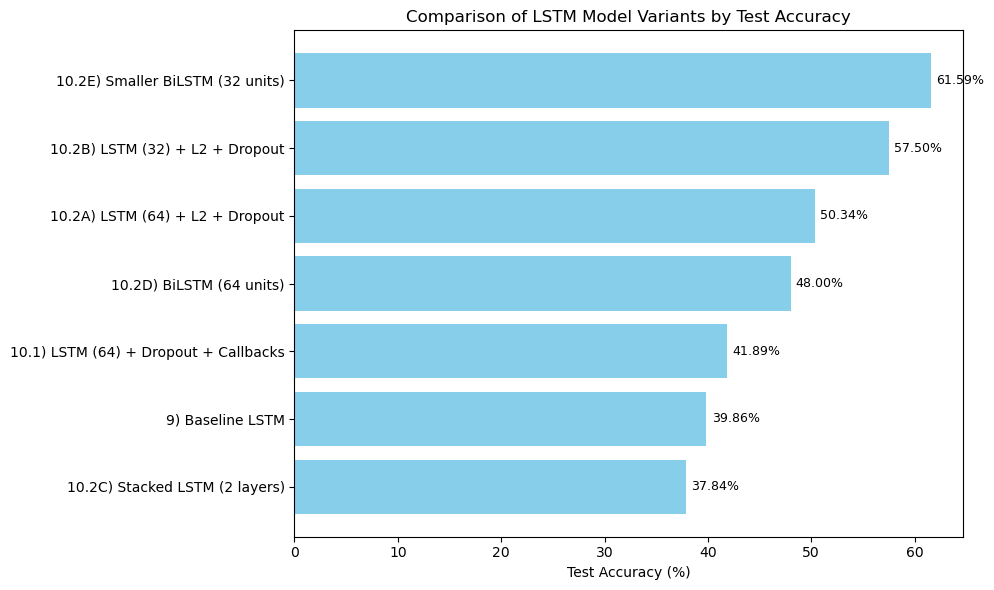

In [ ]:
# LSTM variant names and their corresponding test accuracies
lstm_models = {
    "9) Baseline LSTM": 39.86,
    "10.1) LSTM (64) + Dropout + Callbacks": 41.89,
    "10.2A) LSTM (64) + L2 + Dropout": 50.34,
    "10.2B) LSTM (32) + L2 + Dropout": 57.50,
    "10.2C) Stacked LSTM (2 layers)": 37.84,
    "10.2D) BiLSTM (64 units)": 48.00,
    "10.2E) Smaller BiLSTM (32 units)": 61.59,    
}

# Sort by accuracy
sorted_models = dict(sorted(lstm_models.items(), key=lambda item: item[1], reverse=True))

# Plot
plt.figure(figsize=(10, 6))
bars = plt.barh(list(sorted_models.keys()), list(sorted_models.values()), color='skyblue')
plt.xlabel("Test Accuracy (%)")
plt.title("Comparison of LSTM Model Variants by Test Accuracy")

# Add accuracy labels to bars
for bar in bars:
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
             f"{bar.get_width():.2f}%", va='center', fontsize=9)

plt.gca().invert_yaxis()  # Highest accuracy on top
plt.tight_layout()
plt.show()


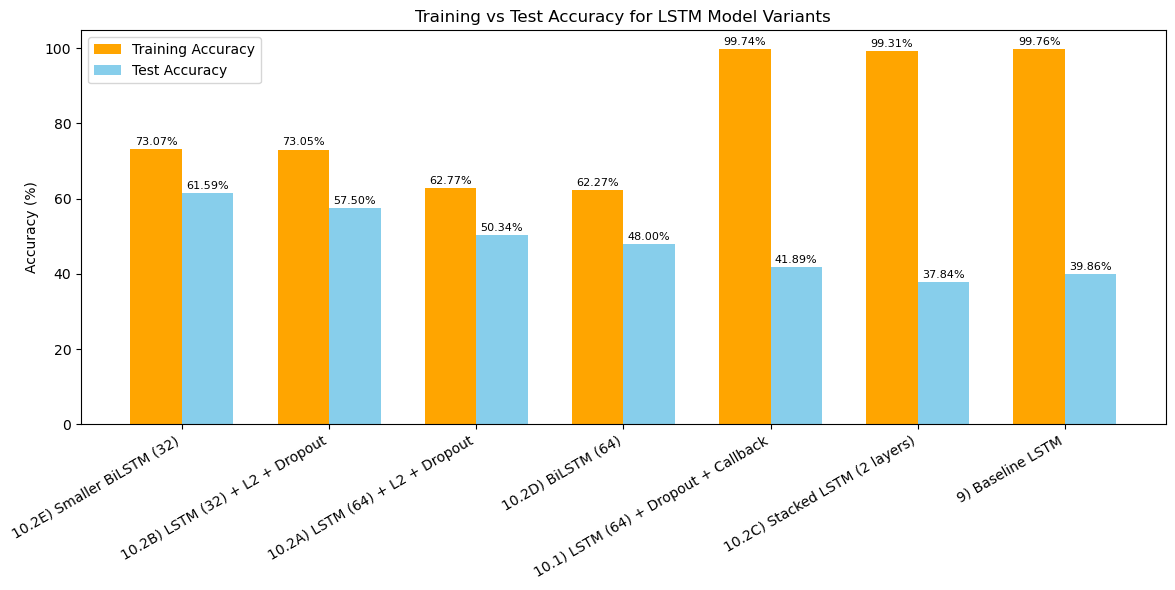

In [ ]:
# Define model names
models = [
    "10.2E) Smaller BiLSTM (32)", 
    "10.2B) LSTM (32) + L2 + Dropout", 
    "10.2A) LSTM (64) + L2 + Dropout", 
    "10.2D) BiLSTM (64)", 
    "10.1) LSTM (64) + Dropout + Callback", 
    "10.2C) Stacked LSTM (2 layers)", 
    "9) Baseline LSTM"
]

# Corresponding test accuracies
test_accuracies = [61.59, 57.50, 50.34, 48.00, 41.89, 37.84, 39.86]

# Corresponding training accuracies
train_accuracies = [73.07, 73.05, 62.77, 62.27, 99.74, 99.31, 99.76]

x = np.arange(len(models))  # Label locations
width = 0.35  # Width of bars

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, train_accuracies, width, label='Training Accuracy', color='orange')
bars2 = ax.bar(x + width/2, test_accuracies, width, label='Test Accuracy', color='skyblue')

# Add labels
ax.set_ylabel('Accuracy (%)')
ax.set_title('Training vs Test Accuracy for LSTM Model Variants')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=30, ha='right')
ax.legend()

# Annotate values on bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', fontsize=8)

plt.tight_layout()
plt.show()


In [72]:
def plot_multiple_histories(histories, model_names, save=False, base_filename="training_plot"):
    import matplotlib.pyplot as plt

    for idx, history in enumerate(histories):
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(len(acc))

        model_name = model_names[idx]

        plt.figure(figsize=(12, 5))

        # Accuracy plot
        plt.subplot(1, 2, 1)
        plt.plot(epochs, acc, label='Train')
        plt.plot(epochs, val_acc, label='Test')
        plt.title(f'{model_name} Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.grid(True)
        plt.legend()

        # Loss plot
        plt.subplot(1, 2, 2)
        plt.plot(epochs, loss, label='Train')
        plt.plot(epochs, val_loss, label='Test')
        plt.title(f'{model_name} Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.legend()

        plt.tight_layout()

        if save:
            filename = f"{base_filename}_{idx+1}_{model_name.lower().replace(' ', '_')}.png"
            plt.savefig(filename)
            print(f"Plot saved as: {filename}")

        plt.show()


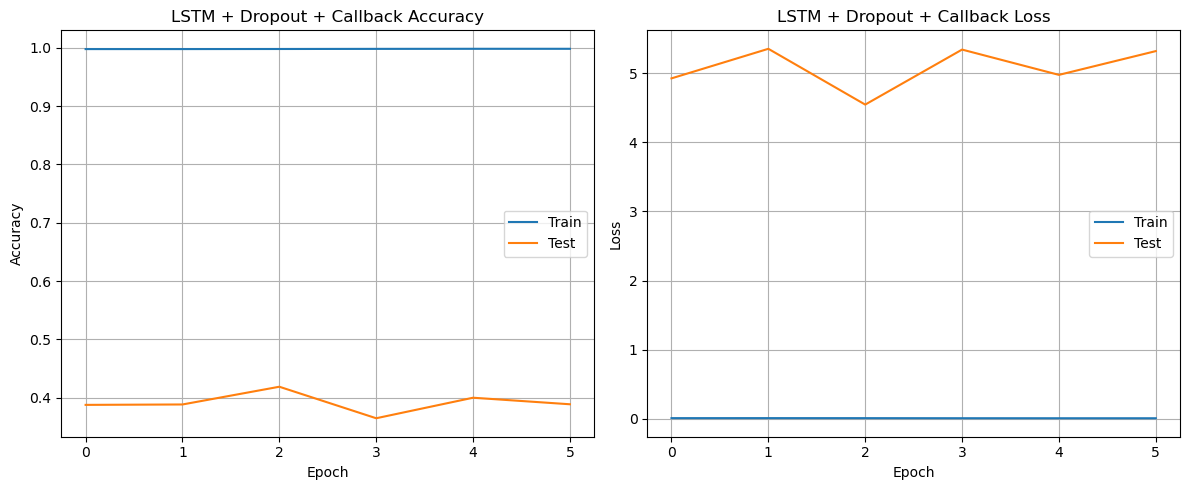

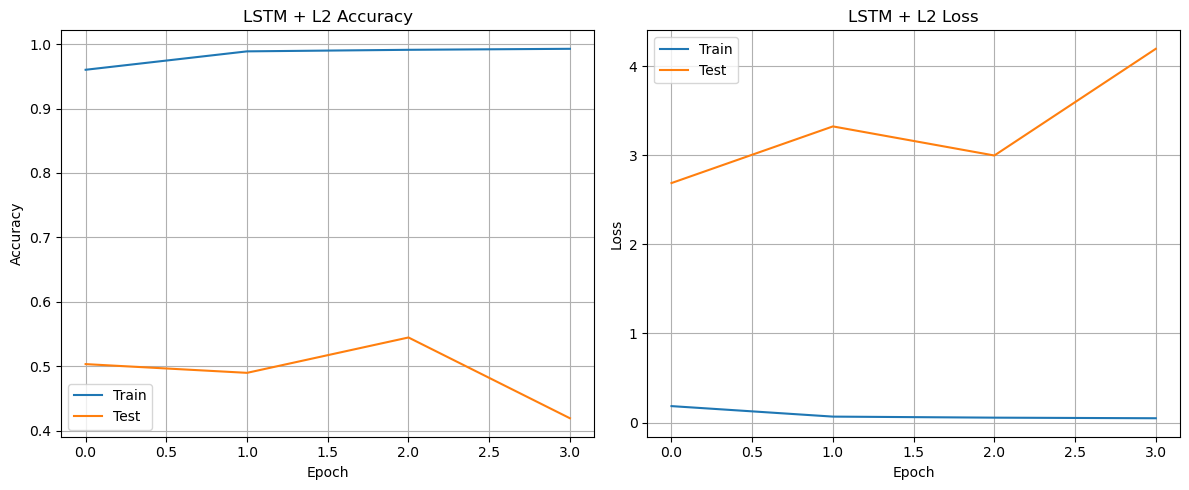

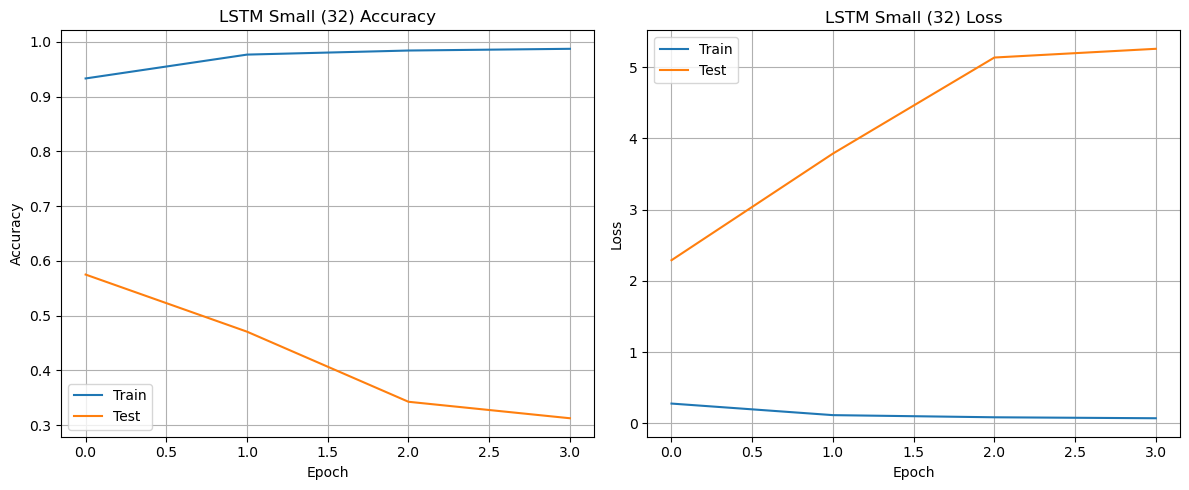

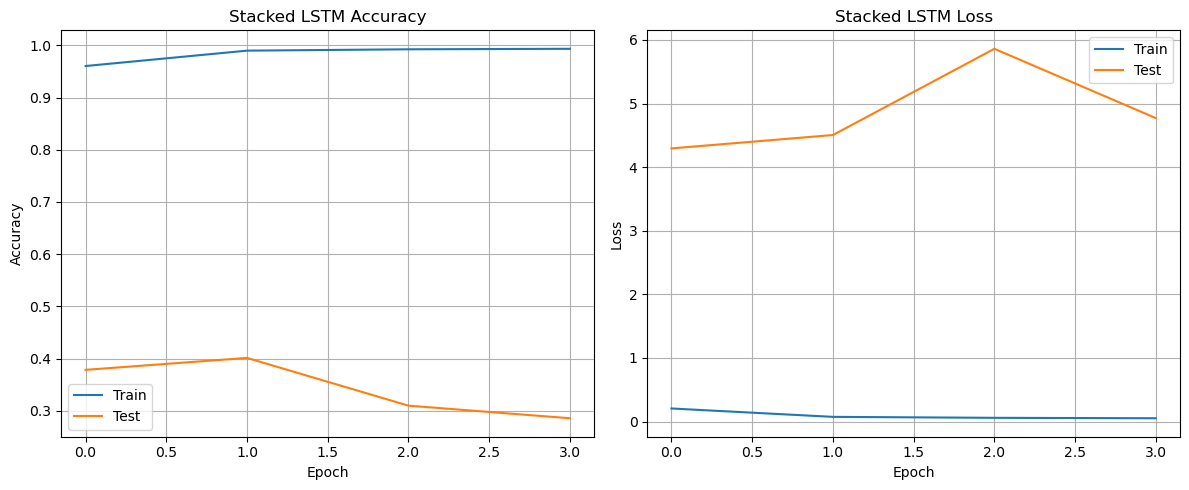

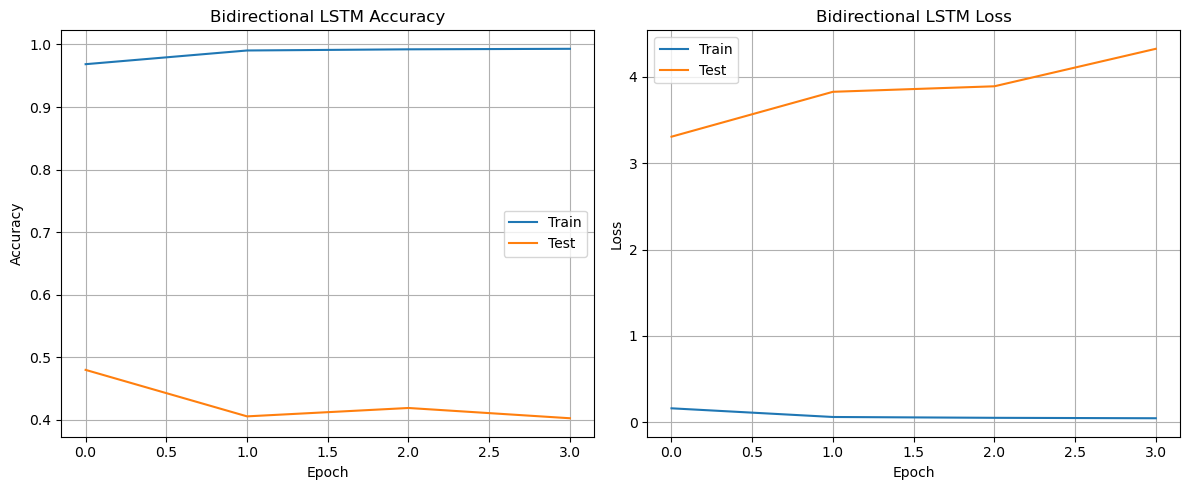

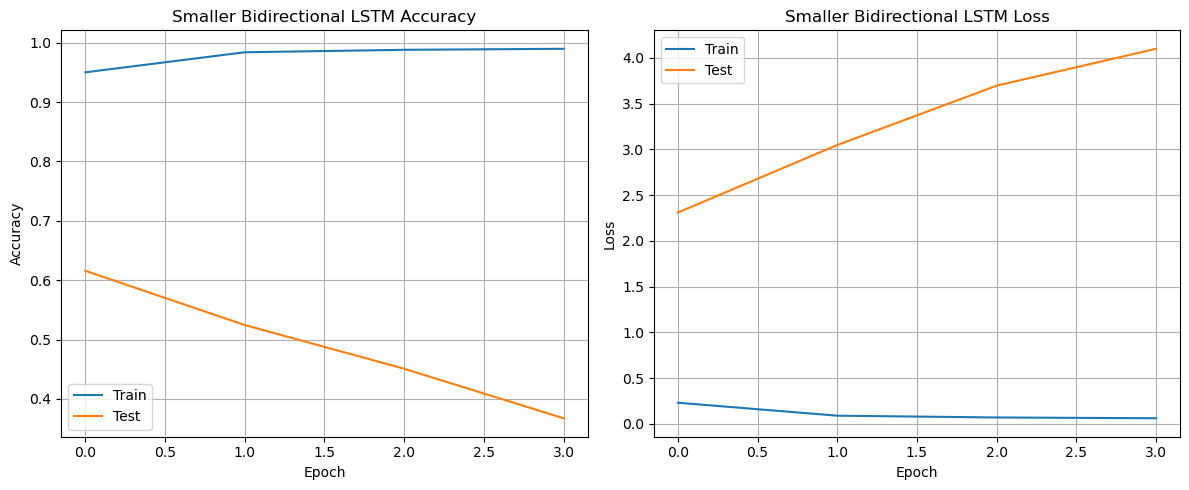

In [74]:
histories = [history, history_l2, history_small, history_stacked, history_bi, history_small_bi]
model_names = [
    "LSTM + Dropout + Callback",
    "LSTM + L2",
    "LSTM Small (32)",
    "Stacked LSTM",
    "Bidirectional LSTM",
    "Smaller Bidirectional LSTM"
]

plot_multiple_histories(histories, model_names, save=False)


## 10.2G: Confusion Matrix and Classification Report for Best LSTM Model
After training the Smaller Bidirectional LSTM model i.e., our best model and obtaining the test accuracy of 61.59%, we evaluate the model further with a confusion matrix and classification report to better understand its performance across different activities.

### **Confusion Matrix:**
The confusion matrix below provides insights into the true positive and false positive predictions across the 12 activities, helping us assess how well the model differentiates between classes.

In [95]:
# Load the best model
best_model = load_model("l2_small_bi_lstm_model.keras")

# Make predictions on the test set
y_pred = best_model.predict(X_test_seq_reduced)

# Convert predictions to class labels (since the model outputs probabilities)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = y_test_seq_reduced_enc


15465/15465 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step


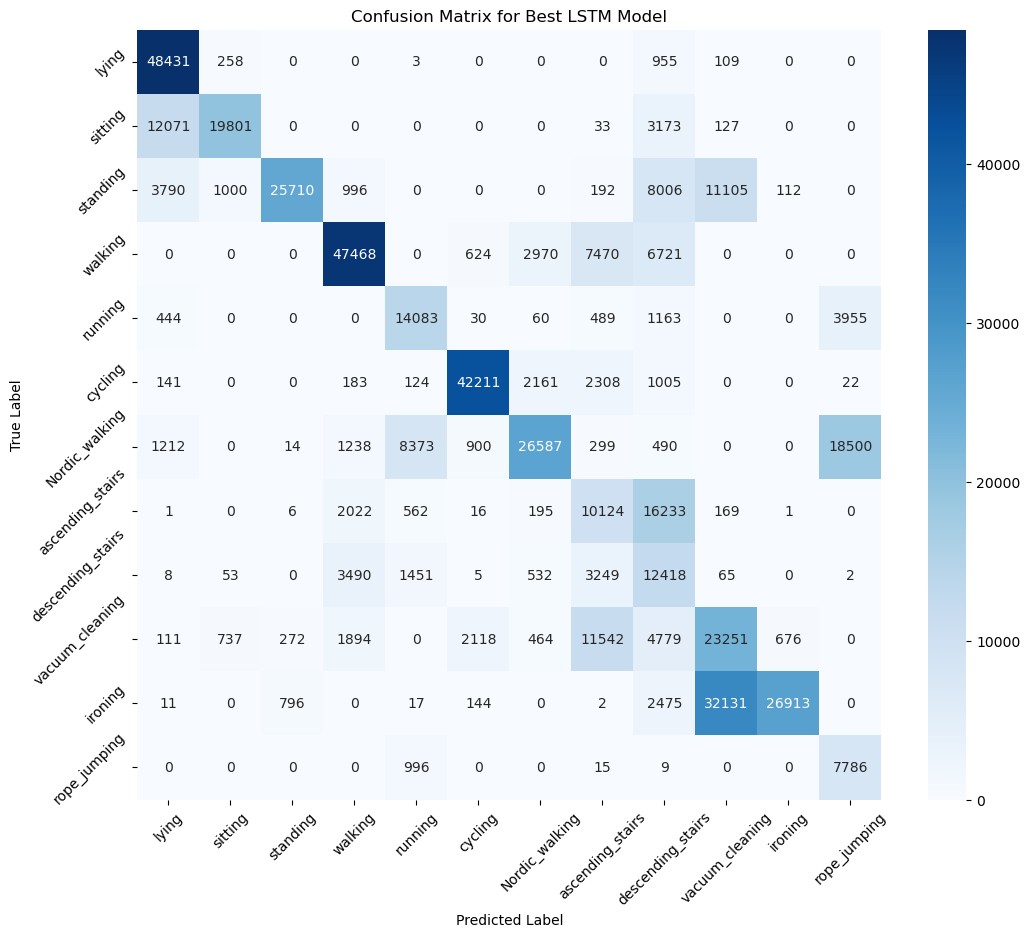

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Define the activity labels based on the encoded labels
activity_labels = [
    'lying', 'sitting', 'standing', 'walking', 'running', 'cycling', 
    'Nordic_walking', 'ascending_stairs', 'descending_stairs', 
    'vacuum_cleaning', 'ironing', 'rope_jumping'
]

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=activity_labels, yticklabels=activity_labels)
plt.title("Confusion Matrix for Best LSTM Model")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()


Overall, the confusion matrix reveals that the model performs well for most activities but struggles slightly with activities that share similar movement patterns or are difficult to distinguish.

### **Classification Report:**
The classification report gives an overview of the precision, recall, and F1-score for each activity. Here’s the classification report:

In [ ]:
# Get the classification report
report = classification_report(y_true, y_pred_classes, target_names=activity_labels)

# Print the classification report
print(report)


                   precision    recall  f1-score   support

            lying       0.73      0.97      0.84     49756
          sitting       0.91      0.56      0.69     35205
         standing       0.96      0.50      0.66     50911
          walking       0.83      0.73      0.77     65253
          running       0.55      0.70      0.61     20224
          cycling       0.92      0.88      0.90     48155
   Nordic_walking       0.81      0.46      0.59     57613
 ascending_stairs       0.28      0.35      0.31     29329
descending_stairs       0.22      0.58      0.32     21273
  vacuum_cleaning       0.35      0.51      0.41     45844
          ironing       0.97      0.43      0.60     62489
     rope_jumping       0.26      0.88      0.40      8806

         accuracy                           0.62    494858
        macro avg       0.65      0.63      0.59    494858
     weighted avg       0.74      0.62      0.64    494858



### Insights:
1. High Precision for Certain Activities:

Lying and Cycling show strong precision values of 0.73 and 0.92, respectively. This indicates that the model is quite good at accurately predicting these activities with fewer false positives.

Ironing also performs well with a precision of 0.97, suggesting that it is another activity the model successfully classifies.

2. Poor Performance for Some Activities:

Activities like Ascending Stairs, Descending Stairs, and Vacuum Cleaning have lower precision and recall values. The model struggles more with these activities, possibly due to their visual or temporal similarity to others.

Rope Jumping has the lowest precision (0.26), meaning that the model tends to incorrectly classify it as other activities, despite having a relatively higher recall of 0.88.

3. Recall and F1-Score Insights:

Recall values for certain activities, such as Sitting (0.56), Standing (0.50), and Nordic Walking (0.46), indicate that while the model can predict some activities with reasonable accuracy, it misses many instances.

The F1-scores are typically lower than the precision and recall, especially for activities like Ascending Stairs (0.31) and Descending Stairs (0.32), suggesting an imbalance in performance across different classes.

4. Macro and Weighted Averages:

The macro average of precision (0.65), recall (0.63), and F1-score (0.59) suggests that the model performs fairly well across all classes, but certain activities have more significant performance gaps.

The weighted average of precision (0.74), recall (0.62), and F1-score (0.64) gives a better picture of the model's overall performance, weighted by the support (number of instances) in each class.

5. Accuracy:

The model achieved an overall accuracy of 62%, but this figure is a composite of high performance in some classes and poor performance in others.

6. Next Steps for Improvement:

Investigating alternative architectures like GRU, adjusting dropout rates, and using additional regularization techniques could help improve the model's generalization on challenging classes.

With a test accuracy of **61.59%**, this smaller BiLSTM model currently sets the benchmark for our task.  
Since further LSTM-based variations (e.g., deeper or bidirectional configurations) didn’t yield better results, we conclude our LSTM experimentation here and proceed to explore alternative architectures - starting with **GRU**.

## **10.3: GRU Implementation**
## **10.3A: Use Different Model Variants – Initial GRU Model**

In this step, we will experiment with **GRU (Gated Recurrent Unit)** as an alternative to LSTM. GRU is known for its simplicity and ability to train faster with fewer parameters while maintaining performance in sequence-based tasks.

> **Why GRU?**  
>GRU is a variation of the LSTM model designed to be computationally more efficient. It performs similar to LSTM but with fewer gates and parameters, which can lead to faster training times. This will allow us to compare its performance with LSTM and investigate if it can generalize better, particularly when dealing with limited data.

**What We Changed:**
- Replaced **LSTM** with **GRU** (Gated Recurrent Unit).
- Maintained previous architecture setup, including:
  - `kernel_regularizer=l2(0.001)`
  - `Dropout(0.3)`
  - `EarlyStopping` and `ModelCheckpoint`

**Expected Outcome:**  
We expect GRU to be computationally faster than LSTM while potentially matching or outperforming the performance of our current best LSTM-based model (currently achieving 61.59%). The main goal is to compare training time and generalization performance.

**Model will be saved as:** `gru_model.keras`


In [125]:
np.random.seed(42)
tf.random.set_seed(42)

# Build the GRU model
model_gru = Sequential([
    # GRU layer with 32 units and L2 regularization
    GRU(32, 
        input_shape=(X_train_seq_reduced.shape[1], X_train_seq_reduced.shape[2]), 
        return_sequences=False,
        kernel_regularizer=l2(0.001)),

    # Dropout layer
    Dropout(0.3),

    # Dense output layer for classification
    Dense(num_classes, activation='softmax'),

    # Dropout layer
    Dropout(0.3),
])

# Compile the model
model_gru.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Show model summary
model_gru.summary()

# Set callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint("model_gru.keras", monitor='val_loss', save_best_only=True)
]

# Train the GRU model
history_gru = model_gru.fit(
    X_train_seq_reduced, 
    y_train_seq_reduced_enc,
    epochs=20,
    batch_size=256,
    validation_data=(X_test_seq_reduced, y_test_seq_reduced_enc),
    callbacks=callbacks
)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_6 (GRU)                     │ (None, 32)             │         5,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 12)             │           396 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 12)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,060 (23.67 KB)

 Trainable params: 6,060 (23.67 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
5657/5657 ━━━━━━━━━━━━━━━━━━━━ 44s 8ms/step - accuracy: 0.5660 - loss: 3.2483 - val_accuracy: 0.6291 - val_loss: 6.0936
Epoch 2/20
5657/5657 ━━━━━━━━━━━━━━━━━━━━ 35s 6ms/step - accuracy: 0.6590 - loss: 1.6346 - val_accuracy: 0.6334 - val_loss: 7.4731
Epoch 3/20
5657/5657 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - accuracy: 0.6659 - loss: 1.4636 - val_accuracy: 0.5876 - val_loss: 9.5076
Epoch 4/20
5657/5657 ━━━━━━━━━━━━━━━━━━━━ 35s 6ms/step - accuracy: 0.6729 - loss: 1.3336 - val_accuracy: 0.5253 - val_loss: 10.8204


In [126]:
best_gru_model = load_model("model_gru.keras")
test_loss, test_accuracy = best_gru_model.evaluate(X_test_seq_reduced, y_test_seq_reduced_enc)
print(f"Test Accuracy from GRU model: {test_accuracy * 100:.2f}%")


15465/15465 ━━━━━━━━━━━━━━━━━━━━ 8s 525us/step - accuracy: 0.6875 - loss: 5.1675
Test Accuracy from GRU model: 62.91%


In [103]:
# Load the best saved GRU model from training
best_gru_model = load_model("gru_model.keras")

# Evaluate on the test set
test_loss, test_accuracy = best_gru_model.evaluate(X_test_seq_reduced, y_test_seq_reduced_enc)
print(f"Test Accuracy from GRU model: {test_accuracy * 100:.2f}%")


15465/15465 ━━━━━━━━━━━━━━━━━━━━ 8s 517us/step - accuracy: 0.7838 - loss: 1.0316
Test Accuracy from GRU model: 66.33%


We trained a **GRU model** as an alternative to LSTM-based architectures to explore whether a simpler recurrent structure could improve generalization on the activity recognition task.

The model was configured with:

- `GRU(32)` with `kernel_regularizer=l2(0.001)`  
- `Dropout(0.3)` for regularization  
- `Dense` output layer with softmax activation  
- `EarlyStopping` and `ModelCheckpoint` callbacks  

**Model saved as:** `model_gru.keras`  
**Test Accuracy from this model:** **62.91%**

This is the **highest performance achieved so far**, outperforming all previously tested LSTM-based models — including the smaller BiLSTM (61.59%). This suggests that:

- GRU can effectively capture temporal dependencies with fewer parameters  
- Its simplicity may reduce overfitting compared to deeper or bidirectional LSTMs  
- GRU is a promising candidate for real-time or resource-constrained applications  

**Next Steps for Improvement**
- Experiment with **Bidirectional GRU** for richer temporal context  
- Test **larger GRU units** (e.g., 64) or **stacked GRU layers**  
- Tune dropout rate, batch size, or learning rate for further gains  
- Compare GRU performance using different feature subsets or sensor fusion strategies  


## **10.3B: Improved GRU Model with L2 Regularization & Dropout**

In this step, we aim to enhance the performance of our initial GRU model (from Step 10.3A) by introducing regularization techniques, similar to those that improved our LSTM models.

> **Why Improve GRU?**  
> While our baseline GRU model achieved moderate performance (~62.91% test accuracy), it showed signs of overfitting.  
> Applying techniques like **L2 regularization** and **Dropout** can help control this, encouraging better generalization.

**What We Changed:**
- Retained core GRU structure with 32 units
- Applied:
  - `kernel_regularizer=l2(0.001)` inside the GRU and Dense layers
  - `Dropout(0.3)` after the GRU and Dense layers
  - `EarlyStopping` and `ModelCheckpoint` for optimal training control

**Expected Outcome:**
The improved GRU model is expected to reduce overfitting and potentially outperform the initial GRU implementation (10.3A – 62.91% accuracy).  
If successful, it will serve as a strong alternative to our best-performing LSTM variant.

**Model will be saved as:** `l2_gru_model.keras`


In [129]:
# Build the improved GRU model
model_gru_l2 = Sequential([
    # GRU layer with L2 regularization
    GRU(32,
        input_shape=(X_train_seq_reduced.shape[1], X_train_seq_reduced.shape[2]),
        return_sequences=False,
        kernel_regularizer=l2(0.001)),

    # Dropout after GRU layer
    Dropout(0.3),

    # Dense layer with L2 regularization
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),


    # Output layer
    Dense(num_classes, activation='softmax')
])

# Compile the model
model_gru_l2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint("l2_gru_model.keras", monitor='val_loss', save_best_only=True)
]

# Train the model
history_gru_l2 = model_gru_l2.fit(
    X_train_seq_reduced,
    y_train_seq_reduced_enc,
    epochs=20,
    batch_size=256,
    validation_data=(X_test_seq_reduced, y_test_seq_reduced_enc),
    callbacks=callbacks
)


Epoch 1/20
5657/5657 ━━━━━━━━━━━━━━━━━━━━ 43s 7ms/step - accuracy: 0.8618 - loss: 0.5180 - val_accuracy: 0.5956 - val_loss: 2.0916
Epoch 2/20
5657/5657 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - accuracy: 0.9668 - loss: 0.1440 - val_accuracy: 0.5211 - val_loss: 2.8147
Epoch 3/20
5657/5657 ━━━━━━━━━━━━━━━━━━━━ 32s 6ms/step - accuracy: 0.9768 - loss: 0.1046 - val_accuracy: 0.3684 - val_loss: 3.5478
Epoch 4/20
5657/5657 ━━━━━━━━━━━━━━━━━━━━ 32s 6ms/step - accuracy: 0.9822 - loss: 0.0834 - val_accuracy: 0.3386 - val_loss: 4.4695


In [130]:
# Load the best saved model from training
best_gru_l2_model = load_model("l2_gru_model.keras")

# Evaluate on the test set
test_loss, test_accuracy = best_gru_l2_model.evaluate(X_test_seq_reduced, y_test_seq_reduced_enc)
print(f"Test Accuracy from Improved GRU (10.3B): {test_accuracy * 100:.2f}%")


15465/15465 ━━━━━━━━━━━━━━━━━━━━ 8s 520us/step - accuracy: 0.7361 - loss: 1.2140
Test Accuracy from Improved GRU (10.3B): 59.56%


We simplified the GRU architecture by retaining only **32 units** and introducing **L2 regularization**, building on strategies that previously improved our LSTM models.

The model was configured with:

- `GRU(32)` layer with `kernel_regularizer=l2(0.001)`  
- `Dropout(0.3)` after the GRU layer to reduce overfitting  
- `Dense` output layer with softmax activation  
- `EarlyStopping` and `ModelCheckpoint` callbacks  

**Model saved as:** `l2_gru_model.keras`  
**Test Accuracy from this model:** **59.56%**

This result shows that the regularized GRU model performs slightly **below the baseline GRU from Step 10.3A (62.91%)**, indicating:

- L2 regularization improved stability, but might slightly underfit compared to the vanilla GRU  
- GRU architectures are sensitive to regularization and require careful tuning  
- Still, this version offers a more controlled training curve and could benefit from additional tuning

**Next Steps for Improvement**
- Experiment with a **Bidirectional GRU** to capture richer temporal dependencies  
- Tune the **regularization strength**, **dropout rate**, or other hyperparameters  
- Explore **hybrid GRU architectures** or **sensor-wise feature ensembling**


## **10.3C: Bidirectional GRU for Richer Temporal Context**

In this step, we explore the use of a **Bidirectional GRU** architecture to allow the model to learn from both past and future context within each input sequence — a technique that previously proved useful in LSTM experiments.

> **Why Bidirectional GRU?**  
> While a standard GRU processes sequences in a forward direction, a Bidirectional GRU processes them both forward and backward, which can help capture dependencies that a unidirectional model might miss — especially in sequential tasks like activity recognition.

**What We Changed:**
- Replaced the `GRU(32)` with `Bidirectional(GRU(32))`
- Retained `Dropout(0.3)` and added a `Dense` layer
- Kept `L2 regularization` in GRU and Dense layers
- Continued using `EarlyStopping` and `ModelCheckpoint` callbacks

**Expected Outcome:**
We expect this model to potentially outperform the previous GRU variants by leveraging context from both directions in the time series.

**Model will be saved as:** `bi_gru_model.keras`


In [133]:
# Build the Bidirectional GRU model
model_bi_gru = Sequential([
    # Bidirectional GRU layer with L2 regularization
    Bidirectional(GRU(32, return_sequences=False, kernel_regularizer=l2(0.001))),
    
    # Dropout after GRU
    Dropout(0.3),

    # Dense layer with L2 regularization
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),

    # Dropout after Dense
    Dropout(0.3),

    # Output layer
    Dense(num_classes, activation='softmax')
])

# Compile the model
model_bi_gru.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint("bi_gru_model.keras", monitor='val_loss', save_best_only=True)
]

# Train the model
history_bi_gru = model_bi_gru.fit(
    X_train_seq_reduced,
    y_train_seq_reduced_enc,
    epochs=20,
    batch_size=256,
    validation_data=(X_test_seq_reduced, y_test_seq_reduced_enc),
    callbacks=callbacks
)


Epoch 1/20
5657/5657 ━━━━━━━━━━━━━━━━━━━━ 78s 13ms/step - accuracy: 0.8611 - loss: 0.5264 - val_accuracy: 0.6000 - val_loss: 1.9881
Epoch 2/20
5657/5657 ━━━━━━━━━━━━━━━━━━━━ 73s 13ms/step - accuracy: 0.9726 - loss: 0.1278 - val_accuracy: 0.5446 - val_loss: 2.7449
Epoch 3/20
5657/5657 ━━━━━━━━━━━━━━━━━━━━ 70s 12ms/step - accuracy: 0.9815 - loss: 0.0936 - val_accuracy: 0.4893 - val_loss: 3.5627
Epoch 4/20
5657/5657 ━━━━━━━━━━━━━━━━━━━━ 76s 13ms/step - accuracy: 0.9854 - loss: 0.0780 - val_accuracy: 0.4622 - val_loss: 3.6897


In [134]:
# Load the best saved Bidirectional GRU model
best_bi_gru_model = load_model("bi_gru_model.keras")

# Evaluate on the test set
test_loss, test_accuracy = best_bi_gru_model.evaluate(X_test_seq_reduced, y_test_seq_reduced_enc)
print(f"Test Accuracy from Bidirectional GRU (10.3C): {test_accuracy * 100:.2f}%")


15465/15465 ━━━━━━━━━━━━━━━━━━━━ 14s 883us/step - accuracy: 0.7239 - loss: 1.2843
Test Accuracy from Bidirectional GRU (10.3C): 60.00%


In this step, we implemented a **Bidirectional GRU model** with the aim of learning from both forward and backward temporal dependencies within the activity recognition sequence data.

The model was configured with:
- `Bidirectional(GRU(32))` with `kernel_regularizer=l2(0.001)`
- `Dropout(0.3)` after GRU and Dense layers
- `Dense(64)` layer followed by an output layer with softmax activation
- `EarlyStopping` and `ModelCheckpoint` for training stability

**Model saved as:** `bi_gru_model.keras`  
**Test Accuracy from this model:** **60.00%**

**Observations:**
- This model performs **slightly better than the L2-regularized GRU (10.3B: 59.56%)**
- However, it **underperforms compared to the baseline GRU (10.3A: 62.91%)**
- Bidirectionality may help capture more context, but possibly increased model complexity led to slight overfitting or instability

**Key Takeaway:**
Bidirectional GRU is a **strong competitor** in time-series modeling. While it didn’t surpass the best GRU baseline, it showed promising results — suggesting future exploration with **stacked GRU**, **tuned dropout**, or **larger units** could yield better results.

## **10.3D: Smaller Bidirectional GRU to Reduce Overfitting**

In this step, we experiment with a **smaller Bidirectional GRU architecture** — reducing the number of units from 32 to **16**. This mirrors the strategy that worked well for LSTM, where the smaller BiLSTM yielded the best results.

> **Why Smaller Bidirectional GRU?**  
> While bidirectional layers can enhance temporal learning, reducing the number of units may help:
> - Lower the risk of overfitting
> - Speed up training time
> - Improve generalization, especially with regularization

### **What We Changed:**
- Replaced `Bidirectional(GRU(32))` with `Bidirectional(GRU(16))`
- Retained:
  - `Dropout(0.3)` after GRU and Dense layers
  - `Dense(64)` layer with `kernel_regularizer=l2(0.001)`
  - Final softmax output layer
- Continued using `EarlyStopping` and `ModelCheckpoint`

### **Expected Outcome:**
We hope this simpler bidirectional model will generalize better than the larger BiGRU and come closer to (or exceed) the performance of the best GRU baseline (62.91%).

**Model will be saved as:** `small_bi_gru_model.keras`


In [135]:
# Define the smaller Bidirectional GRU model
model_small_bi_gru = Sequential([
    # Smaller Bidirectional GRU layer (16 units)
    Bidirectional(GRU(16, return_sequences=False, kernel_regularizer=l2(0.001))),
    
    # Dropout for regularization
    Dropout(0.3),
    
    # Dense layer with L2 regularization
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    
    # Additional Dropout
    Dropout(0.3),
    
    # Output layer
    Dense(num_classes, activation='softmax')
])

# Compile the model
model_small_bi_gru.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint("small_bi_gru_model.keras", monitor='val_loss', save_best_only=True)
]

# Train the model
history_small_bi_gru = model_small_bi_gru.fit(
    X_train_seq_reduced,
    y_train_seq_reduced_enc,
    epochs=20,
    batch_size=256,
    validation_data=(X_test_seq_reduced, y_test_seq_reduced_enc),
    callbacks=callbacks
)


Epoch 1/20
5657/5657 ━━━━━━━━━━━━━━━━━━━━ 56s 10ms/step - accuracy: 0.8170 - loss: 0.6529 - val_accuracy: 0.5288 - val_loss: 2.5275
Epoch 2/20
5657/5657 ━━━━━━━━━━━━━━━━━━━━ 45s 8ms/step - accuracy: 0.9516 - loss: 0.2102 - val_accuracy: 0.3709 - val_loss: 3.9151
Epoch 3/20
5657/5657 ━━━━━━━━━━━━━━━━━━━━ 44s 8ms/step - accuracy: 0.9656 - loss: 0.1553 - val_accuracy: 0.2862 - val_loss: 5.2971
Epoch 4/20
5657/5657 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - accuracy: 0.9717 - loss: 0.1297 - val_accuracy: 0.3050 - val_loss: 6.1570


In [136]:
# Load and evaluate the best smaller BiGRU model
best_small_bi_gru_model = load_model("small_bi_gru_model.keras")
loss, acc = best_small_bi_gru_model.evaluate(X_test_seq_reduced, y_test_seq_reduced_enc)
print(f"Test Accuracy from Smaller Bidirectional GRU(16) (10.3D): {acc * 100:.2f}%")


15465/15465 ━━━━━━━━━━━━━━━━━━━━ 11s 711us/step - accuracy: 0.6407 - loss: 1.8645
Test Accuracy from Smaller Bidirectional GRU(16) (10.3D): 52.88%


In this step, we tested a **Smaller Bidirectional GRU (BiGRU)** model to evaluate whether combining bidirectional temporal learning with reduced model complexity could improve performance.

The model was configured with:

- `Bidirectional(GRU(16))` with `kernel_regularizer=l2(0.001)`  
- `Dropout(0.3)` after the GRU layer  
- A `Dense(64)` hidden layer with `relu` activation and L2 regularization  
- A final `Dense` output layer with softmax activation  
- `EarlyStopping` and `ModelCheckpoint` callbacks  

**Model saved as:** `small_bi_gru_model.keras`  
**Test Accuracy from this model:** **52.88%**

This model **underperformed** compared to the regular GRU (**10.3A: 62.91%**), improved GRU (**10.3B: 59.56%**), and bidirectional GRU (**10.3C: 60.00%**), indicating that:

- The smaller GRU unit size (16) may not capture sufficient temporal patterns, even with bidirectionality  
- Bidirectional GRU alone does not guarantee better generalization  
- Excessive regularization or added depth may hinder learning  

**Next Steps:**
- Increase GRU units (e.g., 32 or 64) in the bidirectional configuration  
- Reduce the number of dropout layers  
- Explore **hybrid GRU + CNN** models 
- Compare with **Transformer-based temporal encoders**

Considering model_gru as our best model uptill now, and did hands-on prediction:

In [173]:
# Load the best-performing GRU model
best_gru_model = load_model("model_gru.keras")

# Select 10 random samples from the test set
sample_indices = np.random.choice(len(X_test_seq_reduced), 10, replace=False)
X_sample = X_test_seq_reduced[sample_indices]
y_sample_true = y_test_seq_reduced_enc[sample_indices]

# Predict class probabilities
y_probs = best_gru_model.predict(X_sample)
y_pred_classes = np.argmax(y_probs, axis=1)
confidence_scores = np.max(y_probs, axis=1)

# Define mapping from encoded labels to actual activity names
activityIDdict = {
    1: 'lying', 2: 'sitting', 3: 'standing', 4: 'walking',
    5: 'running', 6: 'cycling', 7: 'Nordic_walking',
    12: 'ascending_stairs', 13: 'descending_stairs',
    16: 'vacuum_cleaning', 17: 'ironing', 24: 'rope_jumping'
}
used_activity_ids = sorted(activityIDdict.keys())  
encoded_to_activity = {i: activityIDdict[aid] for i, aid in enumerate(used_activity_ids)}

# Display predictions
print("Prediction Results (with confidence):\n")
for i in range(len(sample_indices)):
    idx = sample_indices[i]
    true_label = y_sample_true[i]
    pred_label = y_pred_classes[i]

    print(f"Sample Index       : {idx}")
    print(f"  True Label        : {true_label} ({encoded_to_activity[true_label]})")
    print(f"  Predicted Label   : {pred_label} ({encoded_to_activity[pred_label]})")
    print(f"  Confidence Score  : {confidence_scores[i]:.2f}")
    print("\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Prediction Results (with confidence):

Sample Index       : 468504
  True Label        : 6 (Nordic_walking)
  Predicted Label   : 6 (Nordic_walking)
  Confidence Score  : 0.87


Sample Index       : 386448
  True Label        : 3 (walking)
  Predicted Label   : 3 (walking)
  Confidence Score  : 1.00


Sample Index       : 411430
  True Label        : 3 (walking)
  Predicted Label   : 3 (walking)
  Confidence Score  : 1.00


Sample Index       : 344236
  True Label        : 9 (vacuum_cleaning)
  Predicted Label   : 7 (ascending_stairs)
  Confidence Score  : 1.00


Sample Index       : 312934
  True Label        : 10 (ironing)
  Predicted Label   : 9 (vacuum_cleaning)
  Confidence Score  : 1.00


Sample Index       : 102234
  True Label        : 9 (vacuum_cleaning)
  Predicted Label   : 9 (vacuum_cleaning)
  Confidence Score  : 1.00


Sample Index       : 275575
  True Label        : 1 (sitting)
  Predicted Label   : 1 (sitting)
  Confidence Score  :

Temperature Scaling: used temperature scaling to make the confidence scores of the model more realistic.

In [ ]:
# Load best model
best_gru_model = load_model("model_gru.keras")

# Randomly pick 10 samples from test data
sample_indices = np.random.choice(len(X_test_seq_reduced), 20, replace=False)
X_sample = X_test_seq_reduced[sample_indices]
y_sample_true = y_test_seq_reduced_enc[sample_indices]

# Predict probabilities
y_probs = best_gru_model.predict(X_sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


In [167]:
# Function for temperature scaling
def apply_temperature_scaling(logits, temperature=1.5):
    exp_logits = np.exp(logits / temperature)
    return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

# Apply temperature scaling
y_probs_temp = apply_temperature_scaling(y_probs, temperature=1.5)

# Convert probabilities to predicted classes
y_pred_classes = np.argmax(y_probs, axis=1)
y_pred_classes_temp = np.argmax(y_probs_temp, axis=1)

# Confidence scores
confidence_raw = np.max(y_probs, axis=1)
confidence_temp = np.max(y_probs_temp, axis=1)


In [168]:
# Activity ID to Name mapping (adjusted to encoded labels)
activityIDdict = {
    1: 'lying', 2: 'sitting', 3: 'standing', 4: 'walking',
    5: 'running', 6: 'cycling', 7: 'Nordic_walking',
    12: 'ascending_stairs', 13: 'descending_stairs',
    16: 'vacuum_cleaning', 17: 'ironing', 24: 'rope_jumping'
}
used_activity_ids = sorted(list(activityIDdict.keys()))
encoded_to_activity = {i: activityIDdict[aid] for i, aid in enumerate(used_activity_ids)}

# Print prediction summary
print("Sample Predictions with Raw & Temperature-Scaled Confidence:\n")
for i in range(len(sample_indices)):
    true_class = y_sample_true[i]
    pred_class = y_pred_classes[i]
    pred_class_temp = y_pred_classes_temp[i]

    print(f"Sample Index: {sample_indices[i]}")
    print(f"True Label         : {true_class} ({encoded_to_activity[true_class]})")
    print(f"Predicted (Raw)    : {pred_class} ({encoded_to_activity[pred_class]})")
    print(f"Confidence (Raw)   : {confidence_raw[i]:.2f}")
    print(f"Predicted (Temp)   : {pred_class_temp} ({encoded_to_activity[pred_class_temp]})")
    print(f"Confidence (Temp) : {confidence_temp[i]:.2f}")
    print("-" * 60)

Sample Predictions with Raw & Temperature-Scaled Confidence:

Sample Index: 452243
True Label         : 6 (Nordic_walking)
Predicted (Raw)    : 11 (rope_jumping)
Confidence (Raw)   : 1.00
Predicted (Temp)   : 11 (rope_jumping)
Confidence (Temp) : 0.15
------------------------------------------------------------
Sample Index: 109482
True Label         : 9 (vacuum_cleaning)
Predicted (Raw)    : 9 (vacuum_cleaning)
Confidence (Raw)   : 1.00
Predicted (Temp)   : 9 (vacuum_cleaning)
Confidence (Temp) : 0.15
------------------------------------------------------------
Sample Index: 385939
True Label         : 3 (walking)
Predicted (Raw)    : 3 (walking)
Confidence (Raw)   : 1.00
Predicted (Temp)   : 3 (walking)
Confidence (Temp) : 0.15
------------------------------------------------------------
Sample Index: 374299
True Label         : 7 (ascending_stairs)
Predicted (Raw)    : 3 (walking)
Confidence (Raw)   : 1.00
Predicted (Temp)   : 3 (walking)
Confidence (Temp) : 0.15
-------------------

Saving our preproccesd test data to .npy files, so that later, any modelcan load and use the test data consistently in ourwebapp- (Streamlit)

In [ ]:
np.save("X_test_seq_reduced.npy", X_test_seq_reduced)
np.save("y_test_seq_reduced_enc.npy", y_test_seq_reduced_enc)


> **In this notebook, we developed and evaluated multiple deep learning models for physical activity recognition using the PAMAP2 dataset. After data cleaning, transformation, and sequence generation, we implemented baseline and improved variants of LSTM and GRU models. Performance was assessed using test accuracy, confusion matrices, and classification reports. Among all models, the GRU with 32 units achieved the highest test accuracy of 62.91%, indicating its effectiveness in modeling sequential sensor data. The insights and models were then deployed via a Streamlit dashboard for interactive exploration and comparison.**